In [2]:
import openai

import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import math
import re
import csv
import os

from scipy.stats import ttest_rel, ttest_ind
import pingouin as pg
import numpy as np

In [2]:
colours = {
    "Comprehensiveness": "#7d6274",
    "Correctness": "#b0a6bf",
    "Usefulness": "#644c5f",
    "Interpr./Expl.": "#513846",
    "Consideration of Toxicity": "#000000",
    "Minimal": "#eaaacc",
    "Specific": "#e492b6",
    "Role Encouraging": "#e58996",
    "Req. specific": "#db6480",
    "Req. explicit": "#701f62",
    "Young": "#a0d6b4",
    "Mid-Age\nPregeriatric": "#5f9ea0",
    "Geriatric": "#317873",
    "Short": "#ff835a",
    "Verbose": "#ffb69e",
    "List Style": "#a989c4",
    "Paragraph Style": "#5f447b",
    "No Distractor": "#b58174",
    "Distractor": "#7b5146",
    "cautious": "#e30744",
    "definitive": "#6db7c6",
    "Llama 3.2 3B": "#b0ccdf",
    "Qwen 2.5 14B": "#bb71b2",
    "DSR Llama 70B": "#726699",
    "GPT-4o": "#d26161",
    "GPT-4o mini": "#c0c0c0",
    "o3 mini": "#4fa883",
}

model_mapping = {
    "llama-3.2-3b-instruct": "Llama 3.2 3B",
    "qwen2.5-14b-instruct": "Qwen 2.5 14B",
    "deepseek-r1-distill-llama-70b": "DSR Llama 70B",
    "gpt-4o-2024-11-20": "GPT-4o",
    "gpt-4o-mini-2024-07-18": "GPT-4o mini",
    "o3-mini": "o3 mini",
}

metric_mapping = {
    "correctness": "Correctness",
    "comprehensiveness": "Comprehensiveness",
    "usefulness": "Usefulness",
    "interpretability_explainability": "Interpr./Expl.",
    "toxicity": "Consideration of Toxicity",
}

prompt_mapping = {
    "minimal": "Minimal",
    "specific": "Specific",
    "role_encouraging": "Role Encouraging",
    "requirements_specific": "Req. specific",
    "requirements_explicit": "Req. explicit",
}

# prompt_mapping = {
#     "minimal": "Minimal",
#     ":specific": "Specific",
#     "role_encouraging": "Role Encouraging",
#     ":requirements_specific": "Req. specific",
#     ":requirements_explicit": "Req. explicit",
# }

subtask_mapping = {
    "short": "Short",
    "verbose": "Verbose",
    "no_distractor": "No Distractor",
    ":distractor": "Distractor",
    "list": "List Style",
    ":paragraph": "Paragraph Style",
}

age_mapping = {
    "young": "Young",
    "geriatric": "Geriatric",
    "mid-aged/pregeriatric": "Mid-Age\nPregeriatric",
}

intervention_mapping = {
    "caloric_restriction": "CR",
    "caloric_restriction_and_exercise": "CR + Exercise",
    "intermittent_fasting": "IF",
    "exercise": "Exercise",
    "epicatechin": "Epicatechin",
    "fisetin": "Fisetin",
    "spermidine": "Spermidine",
    "rapamycin": "Rapamycin",
}

In [3]:
df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")
df.head()

,model_name,evaluated_model,iterations,metric,case_id,subtask,age,md5_hash,prompt,system_prompt,prompt_type,is_distractor,type,responses,expected_answer,rating,datetime,biochatter_version
0,gpt-4o-mini-2024-07-18,deepseek-r1-distill-llama-70b,2,comprehensiveness,21,rag:longevity:GERD_diet:short:list:distractor:...,geriatric,6234100d60fc5a127fae470e8d502ad6,Q: I'd like to improve the symptoms and slow t...,minimal,list,distractor,intermittent_fasting,"[""<think>Okay, so I'm trying to help this user...",Yes,1.0;1.0;1.0;1.0/1,2025-02-18 17:17:07,0.9.0
1,gpt-4o-mini-2024-07-18,deepseek-r1-distill-llama-70b,2,comprehensiveness,21,rag:longevity:GERD_diet:short:list:distractor:...,geriatric,3e53ee2a98b27da365a00c665a930e9b,Q: I'd like to improve the symptoms and slow t...,requirements_explicit,list,distractor,intermittent_fasting,"[""<think>Okay, so I'm trying to help this user...",Yes,1.0;1.0;1.0;1.0/1,2025-02-18 17:17:12,0.9.0
2,gpt-4o-mini-2024-07-18,deepseek-r1-distill-llama-70b,2,comprehensiveness,21,rag:longevity:GERD_diet:short:list:distractor:...,geriatric,352690d1f47c777c4564450f6da8fe5e,Q: I'd like to improve the symptoms and slow t...,requirements_specific,list,distractor,intermittent_fasting,"[""<think>Okay, so I'm trying to help this user...",Yes,1.0;1.0;1.0;1.0/1,2025-02-18 17:17:18,0.9.0
3,gpt-4o-mini-2024-07-18,deepseek-r1-distill-llama-70b,2,comprehensiveness,21,rag:longevity:GERD_diet:short:list:distractor:...,geriatric,f2e6689b6bc7b99d1692ef2e0e9a6f1a,Q: I'd like to improve the symptoms and slow t...,role_encouraging,list,distractor,intermittent_fasting,"[""<think>Okay, so I'm trying to help this user...",Yes,1.0;1.0;1.0;1.0/1,2025-02-18 17:17:23,0.9.0
4,gpt-4o-mini-2024-07-18,deepseek-r1-distill-llama-70b,2,comprehensiveness,21,rag:longevity:GERD_diet:short:list:distractor:...,geriatric,de429048945f58842ab6c69135a82574,Q: I'd like to improve the symptoms and slow t...,specific,list,distractor,intermittent_fasting,"[""<think>Okay, so I'm trying to help this user...",Yes,1.0;1.0;1.0;1.0/1,2025-02-18 17:17:28,0.9.0


In [4]:
def score_helper(df):
    if df.empty:
        print("Input DataFrame is empty!")
        return None, None, None
    
    raw_results = df.copy()
    
    # Ensure valid `rating` values
    raw_results["rating"] = raw_results["rating"].fillna("0/1")
    raw_results["rating"] = raw_results["rating"].apply(
        lambda x: x if "/" in x else "0/1"
    )
    
    # Calculate scores
    raw_results["score_possible"] = raw_results["rating"].apply(
        lambda x: float(x.split("/")[1])
    )
    raw_results["scores"] = raw_results["rating"].apply(
        lambda x: x.split("/")[0]
    )
    raw_results["score_achieved_total"] = raw_results["scores"].apply(
        lambda x: np.sum([float(score) for score in x.split(";")])
    )
    raw_results["iteration_scores"] = raw_results["scores"].apply(
        lambda x: [float(score) for score in x.split(";")]
    )
    raw_results["iteration_index"] = raw_results["iteration_scores"].apply(
        lambda x: list(range(1, len(x) + 1))
    )

    # Explode iteration scores and indexes
    exploded_results = raw_results.explode(["iteration_scores", "iteration_index"])
    exploded_results["iteration_scores"] = exploded_results["iteration_scores"].astype(float)
    exploded_results["iteration_index"] = exploded_results["iteration_index"].astype(int)

    # Aggregate per iteration
    aggregated_results_iteration = exploded_results.groupby(["evaluated_model", "iteration_index"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("iteration_scores", "sum"),
    ).reset_index()

    aggregated_results_iteration["score"] = aggregated_results_iteration["score_achieved_total"] / aggregated_results_iteration["score_possible"]

    # Aggregate overall
    aggregated_scores = raw_results.groupby(["evaluated_model"]).agg(
        score_possible=("score_possible", "sum"),
        score_achieved_total=("score_achieved_total", "sum"),
        iterations=("iterations", "first")
    ).reset_index()

    # Validate raw_results shape
    if raw_results.shape[1] < 3:
        raise ValueError("raw_results does not have the required number of columns.")

    # Final score calculations
    # aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * raw_results.iloc[:, 2].iloc[0]
    aggregated_scores['score_possible_total'] = aggregated_scores['score_possible'] * 4
    aggregated_scores['score_achieved_avg'] = aggregated_scores['score_achieved_total'] / raw_results.iloc[:, 2].iloc[0]

    score = aggregated_scores["score_achieved_total"] / aggregated_scores["score_possible_total"]
    aggregated_scores["score"] = score

    std_results = aggregated_results_iteration.groupby(["evaluated_model"])["score"].std().reset_index()
    aggregated_scores['score_achieved_std'] = std_results.iloc[:, 1]

    return exploded_results, raw_results, aggregated_scores, aggregated_results_iteration, std_results

In [5]:
# Function to extract binary score
def process_rating(rating):
    scores = [float(x) for x in rating.split(";")[:-1]]  # Extract scores before the final "/1"
    mean_score = np.mean(scores)  # Compute mean
    return 1 if mean_score > 0.5 else 0  # Convert to binary

In [6]:
def map_columns(
    df, 
    metric_mapping = None, 
    prompt_mapping = None, 
    model_mapping = None,
    subtask_mapping = None,
    age_mapping = None,
    intervention_mapping = None,
):
    if metric_mapping:
        df["metric"] = df["metric"].map(metric_mapping)
    if prompt_mapping:
        df["system_prompt"] = df["system_prompt"].map(prompt_mapping)
    if model_mapping:
        df["evaluated_model"] = df["evaluated_model"].map(model_mapping)
    if subtask_mapping:
        df["subtask"] = df["subtask"].map(subtask_mapping)
    if age_mapping:
        df["age_group"] = df["age_group"].map(age_mapping)
    if intervention_mapping:
        df["intervention"] = df["intervention"].map(intervention_mapping)
    return df

In [7]:
def create_frames(df):
    models = list(df["evaluated_model"].unique())

    dfs = []
    for model in models:
        _ = df[df["evaluated_model"] == model]
        dfs.append(_)
    return dfs

## Figure 2. LLM Performance across validation requirements.

[0.19688529 0.19688529        nan 0.19688529 0.35761471        nan
 0.35761471 0.35761471]
0.5
Line2D(_child5)
[0.43933557 0.43933557        nan 0.43933557 0.60666443        nan
 0.60666443 0.60666443]
0.5
Line2D(_child6)
[0.35466094 0.35466094        nan 0.35466094 0.51833906        nan
 0.51833906 0.51833906]
0.5
Line2D(_child7)
[0.42571879 0.42571879        nan 0.42571879 0.64603121        nan
 0.64603121 0.64603121]
0.5
Line2D(_child8)
[0.84348286 0.84348286        nan 0.84348286 0.93376714        nan
 0.93376714 0.93376714]
0.5
Line2D(_child9)
[0.23164515 0.23164515        nan 0.23164515 0.60860485        nan
 0.60860485 0.60860485]
0.5
Line2D(_child15)
[0.66944751 0.66944751        nan 0.66944751 0.68955249        nan
 0.68955249 0.68955249]
0.5
Line2D(_child16)
[0.43271747 0.43271747        nan 0.43271747 0.73828253        nan
 0.73828253 0.73828253]
0.5
Line2D(_child17)
[0.47365156 0.47365156        nan 0.47365156 0.83184844        nan
 0.83184844 0.83184844]
0.5
Line2D(_child1

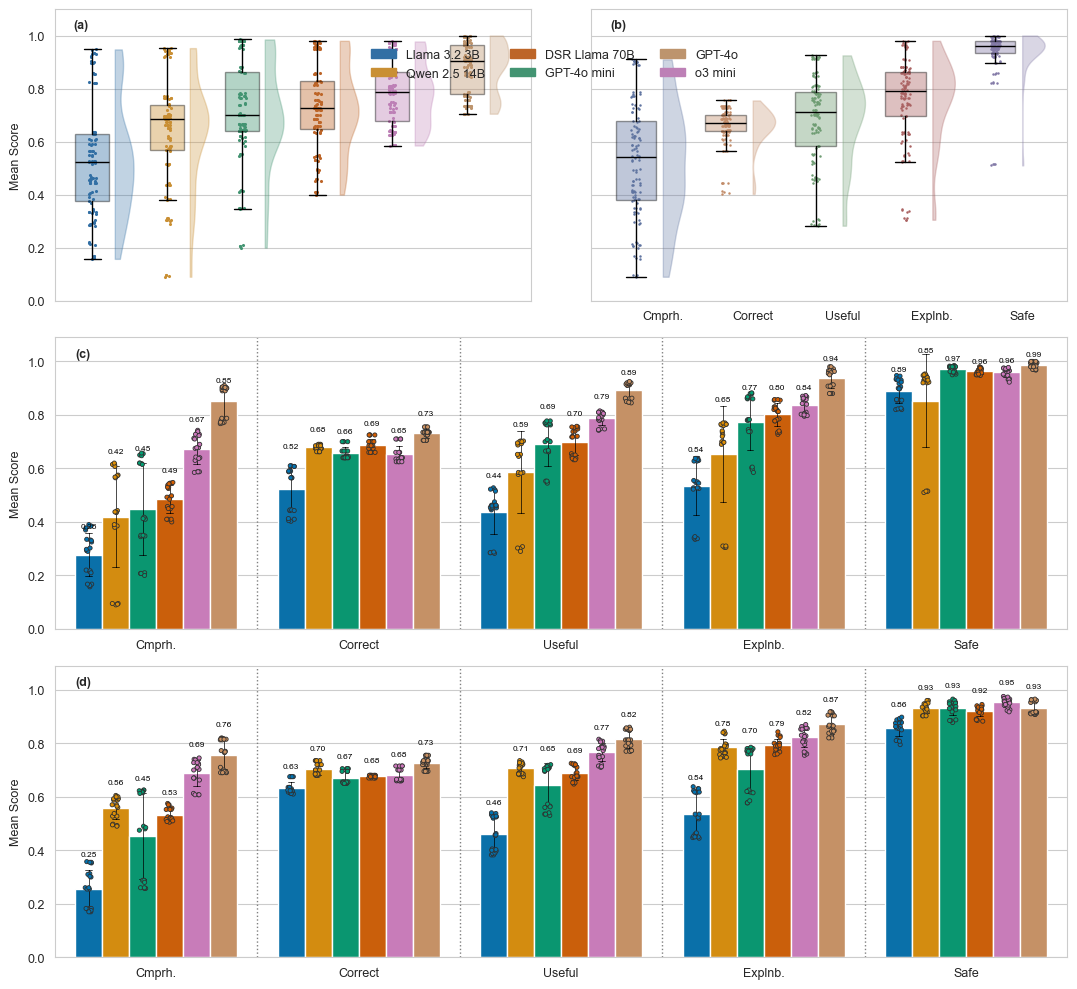

\begin{tabular}{lrrrrr}
\toprule
evaluated_model & Correctness & Comprehensiveness & Usefulness & Interpr./Expl. & Consideration of Toxicity \\
\midrule
Llama 3.2 3B & 0.52 & 0.28 & 0.44 & 0.54 & 0.89 \\
Qwen 2.5 14B & 0.68 & 0.42 & 0.59 & 0.65 & 0.85 \\
GPT-4o mini & 0.66 & 0.45 & 0.69 & 0.77 & 0.97 \\
DSR Llama 70B & 0.69 & 0.49 & 0.70 & 0.80 & 0.96 \\
o3 mini & 0.65 & 0.67 & 0.79 & 0.84 & 0.96 \\
GPT-4o & 0.73 & 0.85 & 0.89 & 0.94 & 0.99 \\
\bottomrule
\end{tabular}



In [8]:
from cmcrameri import cm
import matplotlib.gridspec as gridspec

frames = []
for metric in df["metric"].unique():
    dfs = []
    for sys_prompt in df["system_prompt"].unique():
        df_helper = score_helper(df[(df["metric"] == metric) &
                                    (df["system_prompt"] == sys_prompt) &
                                    (df["subtask"].str.startswith("longevity"))])[3]
        df_helper["metric"] = metric
        df_helper["system_prompt"] = sys_prompt
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip = pd.concat(frames, ignore_index = True)
df_strip = map_columns(df = df_strip, metric_mapping = metric_mapping, model_mapping = model_mapping, prompt_mapping = prompt_mapping) 

custom_metric_order = ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"]
custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip["metric"] = pd.Categorical(df_strip["metric"], categories = custom_metric_order, ordered = True)

df_strip = df_strip.reset_index(drop = True)

df_strip.loc[df_strip["metric"] == "Consideration of Toxicity", "score"] = 1 - df_strip["score"]

sns.set_style(style = "whitegrid")

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(ncols = 8, nrows = 3, figure=fig)

axs = [
    fig.add_subplot(gs[0, 1:4]),
    fig.add_subplot(gs[0, 4:7]),
    fig.add_subplot(gs[1, 1:7]),
    fig.add_subplot(gs[2, 1:7]),
]

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for metric, pretty_metric in metric_mapping.items():
        df_helper = score_helper(df = df[
            (df["evaluated_model"] == model) &
            (df["metric"] == metric)
        ])[3]
        df_helper["metric"] = metric
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df = pd.concat(bplt_dfs, ignore_index = True)
bplt_df = map_columns(df = bplt_df, model_mapping = model_mapping, metric_mapping = metric_mapping)
bplt_df.reset_index(drop = True)
bplt_df.loc[bplt_df["metric"] == "Consideration of Toxicity", "score"] = 1 - bplt_df["score"]

hue_order = (
    bplt_df.groupby('evaluated_model')['score']
    .mean()
    .sort_values(ascending=True)
    .index
    .tolist()
)

bplt_df["evaluated_model"] = pd.Categorical(bplt_df["evaluated_model"], categories=hue_order, ordered=True)
bplt_df["metric"] = pd.Categorical(bplt_df["metric"], categories = custom_metric_order, ordered = True)
df_strip["evaluated_model"] = pd.Categorical(df_strip["evaluated_model"], categories = hue_order, ordered = True)

df_data_mod = [
    df_strip[df_strip["evaluated_model"] == "Llama 3.2 3B"]["score"], 
    df_strip[df_strip["evaluated_model"] == "Qwen 2.5 14B"]["score"],
    df_strip[df_strip["evaluated_model"] == "GPT-4o mini"]["score"],
    df_strip[df_strip["evaluated_model"] == "DSR Llama 70B"]["score"],
    df_strip[df_strip["evaluated_model"] == "o3 mini"]["score"],
    df_strip[df_strip["evaluated_model"] == "GPT-4o"]["score"],
]

colors_mod = [(50/255, 111/255, 164/255), (201/255, 143/255, 52/255), (67/255, 148/255, 114/255), (189/255, 101/255, 40/255), (189/255, 128/255, 182/255), (189/255, 148/255, 109/255)]

positions = [i - 0.3 for i in range(1, len(df_data_mod) + 1)]
bp = axs[0].boxplot(
    df_data_mod, 
    patch_artist = True, 
    orientation = "vertical",
    widths = 0.45, 
    showfliers = False, 
    medianprops = {"color": "black"},
    positions = positions,
)

# Change to the desired color and add transparency
for patch, color in zip(bp['boxes'], colors_mod):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

vp = axs[0].violinplot(
    df_data_mod, 
    showmeans=False, 
    showextrema=False, 
    showmedians=False, 
    vert=True,
)

for idx, b in enumerate(vp['bodies']):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx + 1, idx + 1.5)
    b.set_color(colors_mod[idx])

for idx, features in enumerate(df_data_mod):
    x = idx + 0.7 + np.random.uniform(-0.05, 0.05, size = len(features))
    axs[0].scatter(x, features, s = 1.5, color = colors_mod[idx])

axs[0].get_xaxis().set_ticks([])
axs[0].set_ylabel("Mean Score", fontsize = 9)
axs[0].set_ylim(0, 1.1)
axs[0].set_xlabel("")
axs[0].tick_params(axis = "both", labelsize = 9)
axs[0].set_title("(a)", loc = "left", y = 1.0, x = 0.04, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

df_data_req = [
    df_strip[df_strip["metric"] == "Comprehensiveness"]["score"], 
    df_strip[df_strip["metric"] == "Correctness"]["score"],
    df_strip[df_strip["metric"] == "Usefulness"]["score"],
    df_strip[df_strip["metric"] == "Interpr./Expl."]["score"],
    df_strip[df_strip["metric"] == "Consideration of Toxicity"]["score"],
]

colors_req = [(95/255,116/255,160/255), (194/255, 140/255, 105/255), (110/255, 156/255, 114/255), (170/255, 98/255, 98/255), (131/255, 122/255, 167/255)]

positions = [i - 0.3 for i in range(1, len(df_data_req) + 1)]
bp = axs[1].boxplot(
    df_data_req, 
    patch_artist = True, 
    orientation = "vertical",
    widths = 0.45, 
    showfliers = False, 
    medianprops = {"color": "black"},
    positions = positions,
)

for patch, color in zip(bp['boxes'], colors_req):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

vp = axs[1].violinplot(
    df_data_req, 
    showmeans=False, 
    showextrema=False, 
    showmedians=False, 
    vert=True
)

for idx, b in enumerate(vp['bodies']):
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], idx + 1, idx + 1.5)
    b.set_color(colors_req[idx])

for idx, features in enumerate(df_data_req):
    x = idx + 0.7 + np.random.uniform(-0.05, 0.05, size = len(features))
    axs[1].scatter(x, features, s = 0.6, color = colors_req[idx])

axs[1].set_ylim(0, 1.1)
axs[1].set_ylabel("")
# axs[1].get_yaxis().set_ticks([])
axs[1].set_yticklabels([])
axs[1].set_xlabel("")
axs[1].set_xticks(np.arange(1,len(df_data_req)+1,1), ["Cmprh.", "Correct", "Useful", "Explnb.", "Safe"])
axs[1].tick_params(axis = "both", labelsize = 9)
axs[1].tick_params(axis = "y", colors = "white")
axs[1].grid(True, axis = "y")
axs[1].grid(False, axis = "x")
axs[1].set_title("(b)", loc = "left", y = 1.0, x = 0.04, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

plot = sns.barplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_strip,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[2]
)

stripplot = sns.stripplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_strip,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[2]
)

axs[2].legend().set_visible(False)
axs[2].set_ylabel("Mean Score", fontsize = 9)
axs[2].set_ylim(0, 1.09)
axs[2].set_xlabel("")
axs[2].tick_params(axis = "both", labelsize = 9)
axs[2].set_xticks(np.arange(5), ["Cmprh.", "Correct", "Useful", "Explnb.", "Safe"])
axs[2].set_title("(c)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

lines = axs[2].lines
for p in axs[2].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[2].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 1:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    if height >= 0.84 and height <= 0.86:
        extra = -0.04
    elif height > 0.88 and height <= 0.95:
        extra = -0.02
    elif height > 0.95:
        extra = -0.03
    elif height > 0.53 and height < 0.55:
        extra = -0.03
    elif height > 0.652 and height < 0.653:
        extra = -0.03
    elif i == 7:
        extra = -0.03
    elif i == 0:
        extra = -0.03
    elif i == 1:
        extra = +0.02
    elif i == 13:
        extra = -0.03
    elif i == 23:
        extra = -0.02
    else:
        extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:

        axs[2].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

for j in range(len(custom_metric_order) - 1):
    plot.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

frames = []
for metric in df["metric"].unique():
    dfs = []
    for sys_prompt in df["system_prompt"].unique():
        df_helper = score_helper(df[(df["metric"] == metric) &
                                    (df["system_prompt"] == sys_prompt) &
                                    (df["subtask"].str.startswith("rag"))])[3]
        df_helper["metric"] = metric
        df_helper["system_prompt"] = sys_prompt
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip_rag = pd.concat(frames, ignore_index = True)
df_strip_rag = map_columns(df = df_strip_rag, metric_mapping = metric_mapping, model_mapping = model_mapping, prompt_mapping = prompt_mapping) 

custom_metric_order = ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"]
custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip_rag["metric"] = pd.Categorical(df_strip_rag["metric"], categories = custom_metric_order, ordered = True)
df_strip_rag["evaluated_model"] = pd.Categorical(df_strip_rag["evaluated_model"], categories = hue_order, ordered = True)

# Reset index to remove duplicates and drop the old index
df_strip_rag = df_strip_rag.reset_index(drop = True)

# Now replace 'score' for 'Comprehensiveness' with the complement
df_strip_rag.loc[df_strip_rag["metric"] == "Consideration of Toxicity", "score"] = 1 - df_strip_rag["score"]

plot_rag = sns.barplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_strip_rag,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[3]
)

stripplot_rag = sns.stripplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_strip_rag,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[3]
)

axs[3].legend().set_visible(False)
axs[3].set_ylabel("Mean Score", fontsize = 9)
axs[3].set_ylim(0, 1.09)
axs[3].set_xlabel("")
axs[3].tick_params(axis = "both", labelsize = 9)
axs[3].set_xticks(np.arange(5), ["Cmprh.", "Correct", "Useful", "Explnb.", "Safe"])
axs[3].set_title("(d)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

for j in range(len(custom_metric_order) - 1):
    plot_rag.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

lines = axs[3].lines
for p in axs[3].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[3].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 1:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[3].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

import matplotlib.patches as mpatches
llama_patch = mpatches.Patch(color= (50/255, 111/255, 164/255), label='Llama 3.2 3B')
qwen_patch = mpatches.Patch(color=(201/255, 143/255, 52/255), label='Qwen 2.5 14B')
dsr_patch = mpatches.Patch(color=(189/255, 101/255, 40/255), label='DSR Llama 70B')
gpt_4omini_patch = mpatches.Patch(color=(67/255, 148/255, 114/255), label='GPT-4o mini')
gpt_4o_patch = mpatches.Patch(color=(189/255, 148/255, 109/255), label='GPT-4o')
o3mini_patch = mpatches.Patch(color=(189/255, 128/255, 182/255), label='o3 mini')

fig.legend(
    handles=[llama_patch, 
             qwen_patch,
             dsr_patch,
             gpt_4omini_patch,
             gpt_4o_patch,
             o3mini_patch
    ],
    # loc='outside upper center',
    bbox_to_anchor = (0.63, 0.95),
    ncols = len(df_strip["evaluated_model"].unique()) / 2,
    frameon = False,
    borderaxespad = 0.,
    fontsize = 9,
)

# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/figure_2.pdf", dpi = 300, bbox_inches = "tight")
gs.tight_layout(fig)
plt.show()

latex_column_order = [
    "evaluated_model", "Correctness", "Comprehensiveness", 
    "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"
]

latex_df = (
    df_strip.groupby(['evaluated_model', 'metric'], observed=False)['score']
    .mean()
    .unstack('metric')
    .reindex(columns=["Correctness", "Comprehensiveness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"])
    .reset_index()
)
latex_df = latex_df[latex_column_order]
latex_df = latex_df.to_latex(index = False, float_format = "%.2f")

print(latex_df)

In [9]:
df_x = df.copy()

models = [model for model, pretty_model in model_mapping.items()]

final_frame = {}
for metric, pretty_metric in metric_mapping.items():
    for model in models:
        helper_frame = df_x[(df_x["evaluated_model"] == model) &
                            (df_x["subtask"].str.startswith("longevity")) &
                            (df_x["metric"] == metric)].copy()
        helper_frame["binary_rating"] = helper_frame["rating"].apply(process_rating)
        final_frame[model] = list(helper_frame["binary_rating"])

    data = pd.DataFrame(final_frame)
    keys = list(final_frame.keys())

    print(f"\033[1m{pretty_metric}\033[0m")
    for i in range(len(models) - 1):
        for j in range(i + 1, len(models)):
            chi2 = pg.chi2_mcnemar(data = data, x = models[i], y = models[j])[1]["chi2"].iloc[0]
            p_value = pg.chi2_mcnemar(data = data, x = models[i], y = models[j])[1]["p-approx"].iloc[0]

            print(f"{model_mapping[models[i]]} vs {model_mapping[models[j]]}")
            print(f"chi2: {chi2}")
            print(f"p-value: {p_value * 15}")
            print("")

Correctness
Llama 3.2 3B vs Qwen 2.5 14B
chi2: 57.92111368909513
p-value: 4.092642584223886e-13

Llama 3.2 3B vs DSR Llama 70B
chi2: 66.40941176470588
p-value: 5.495230919108732e-15

Llama 3.2 3B vs GPT-4o
chi2: 109.42928039702234
p-value: 1.9602719990428148e-24

Llama 3.2 3B vs GPT-4o mini
chi2: 47.880102040816325
p-value: 6.796451530068743e-11

Llama 3.2 3B vs o3 mini
chi2: 37.95922746781116
p-value: 1.0835790251224125e-08

Qwen 2.5 14B vs DSR Llama 70B
chi2: 0.313953488372093
p-value: 8.628963589091027

Qwen 2.5 14B vs GPT-4o
chi2: 10.16015625
p-value: 0.021526268695333514

Qwen 2.5 14B vs GPT-4o mini
chi2: 1.702127659574468
p-value: 2.8801494084078474

Qwen 2.5 14B vs o3 mini
chi2: 2.6063348416289593
p-value: 1.5965625613473415

DSR Llama 70B vs GPT-4o
chi2: 9.338888888888889
p-value: 0.033651225739148145

DSR Llama 70B vs GPT-4o mini
chi2: 4.30622009569378
p-value: 0.569598708479835

DSR Llama 70B vs o3 mini
chi2: 4.642570281124498
p-value: 0.467823871509781

GPT-4o vs GPT-4o mini

In [10]:
metrics = [metric for metric, pretty_metric in metric_mapping.items()]

final_frame = {}
for model, pretty_model in model_mapping.items():
    for metric in metrics:
        helper_frame = df_x[(df_x["evaluated_model"] == model) &
                            (df_x["subtask"].str.startswith("longevity")) &
                            (df_x["metric"] == metric)].copy()
        helper_frame["binary_rating"] = helper_frame["rating"].apply(process_rating)
        final_frame[metric] = list(helper_frame["binary_rating"])

    data = pd.DataFrame(final_frame)
    keys = list(final_frame.keys())

    print(f"\033[1m{pretty_model}\033[0m")
    for i in range(len(metrics) - 1):
        for j in range(i + 1, len(metrics)):
            chi2 = pg.chi2_mcnemar(data = data, x = metrics[i], y = metrics[j])[1]["chi2"].iloc[0]
            p_value = pg.chi2_mcnemar(data = data, x = metrics[i], y = metrics[j])[1]["p-approx"].iloc[0]

            print(f"{metric_mapping[metrics[i]]} vs {metric_mapping[metrics[j]]}")
            print(f"chi2: {chi2}")
            print(f"p-value: {p_value * 10}")
            print("")

Llama 3.2 3B
Correctness vs Comprehensiveness
chi2: 157.8850267379679
p-value: 3.279164450830945e-35

Correctness vs Usefulness
chi2: 24.923076923076923
p-value: 5.966393833070146e-06

Correctness vs Interpr./Expl.
chi2: 0.5348101265822784
p-value: 4.645915729739169

Correctness vs Consideration of Toxicity
chi2: 292.15834767641996
p-value: 1.6837507388239536e-64

Comprehensiveness vs Usefulness
chi2: 149.05806451612904
p-value: 2.7851500725026658e-33

Comprehensiveness vs Interpr./Expl.
chi2: 256.00387596899225
p-value: 1.2752674365716637e-56

Comprehensiveness vs Consideration of Toxicity
chi2: 73.69190600522194
p-value: 9.131253977515376e-17

Usefulness vs Interpr./Expl.
chi2: 89.38842975206612
p-value: 3.244284505860899e-20

Usefulness vs Consideration of Toxicity
chi2: 192.96067415730337
p-value: 7.179685221469879e-43

Interpr./Expl. vs Consideration of Toxicity
chi2: 292.231884057971
p-value: 1.6227637421215632e-64

Qwen 2.5 14B
Correctness vs Comprehensiveness
chi2: 187.04087193

## Figure 3. LLM performance across various system prompts and diseases.

/var/folders/g2/71rvhczs5jz338chhbpn8yh1w8w73f/T/ipykernel_3208/1504416762.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_strip.groupby('evaluated_model')['score']


[0.23082949 0.23082949        nan 0.23082949 0.28742051        nan
 0.28742051 0.28742051]
0.5
Line2D(_child5)
[0.39159614 0.39159614        nan 0.39159614 0.43740386        nan
 0.43740386 0.43740386]
0.5
Line2D(_child6)
[0.41073385 0.41073385        nan 0.41073385 0.44726615        nan
 0.44726615 0.44726615]
0.5
Line2D(_child7)
[0.40009315 0.40009315        nan 0.40009315 0.48015685        nan
 0.48015685 0.48015685]
0.5
Line2D(_child8)
[0.31215809 0.31215809        nan 0.31215809 0.42159191        nan
 0.42159191 0.42159191]
0.5
Line2D(_child9)
[0.47650439 0.47650439        nan 0.47650439 0.48624561        nan
 0.48624561 0.48624561]
0.5
Line2D(_child15)
[0.45811153 0.45811153        nan 0.45811153 0.46701347        nan
 0.46701347 0.46701347]
0.5
Line2D(_child16)
[0.5087889 0.5087889       nan 0.5087889 0.5232111       nan 0.5232111
 0.5232111]
0.5
Line2D(_child17)
[0.54199252 0.54199252        nan 0.54199252 0.56850748        nan
 0.56850748 0.56850748]
0.5
Line2D(_child18)
[0.55

/var/folders/g2/71rvhczs5jz338chhbpn8yh1w8w73f/T/ipykernel_3208/1504416762.py:295: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_strip.groupby('evaluated_model')['score']


[0.26153017 0.26153017        nan 0.26153017 0.40665165        nan
 0.40665165 0.40665165]
0.5
Line2D(_child3)
[0.28094708 0.28094708        nan 0.28094708 0.44735649        nan
 0.44735649 0.44735649]
0.5
Line2D(_child4)
[0.41949811 0.41949811        nan 0.41949811 0.53023403        nan
 0.53023403 0.53023403]
0.5
Line2D(_child5)
[0.41498034 0.41498034        nan 0.41498034 0.52803103        nan
 0.52803103 0.52803103]
0.5
Line2D(_child9)
[0.4369924  0.4369924         nan 0.4369924  0.49604331        nan
 0.49604331 0.49604331]
0.5
Line2D(_child10)
[0.59557625 0.59557625        nan 0.59557625 0.67299518        nan
 0.67299518 0.67299518]
0.5
Line2D(_child11)
[0.41401798 0.41401798        nan 0.41401798 0.54649338        nan
 0.54649338 0.54649338]
0.5
Line2D(_child15)
[0.45531397 0.45531397        nan 0.45531397 0.52513246        nan
 0.52513246 0.52513246]
0.5
Line2D(_child16)
[0.63779773 0.63779773        nan 0.63779773 0.71675584        nan
 0.71675584 0.71675584]
0.5
Line2D(_child

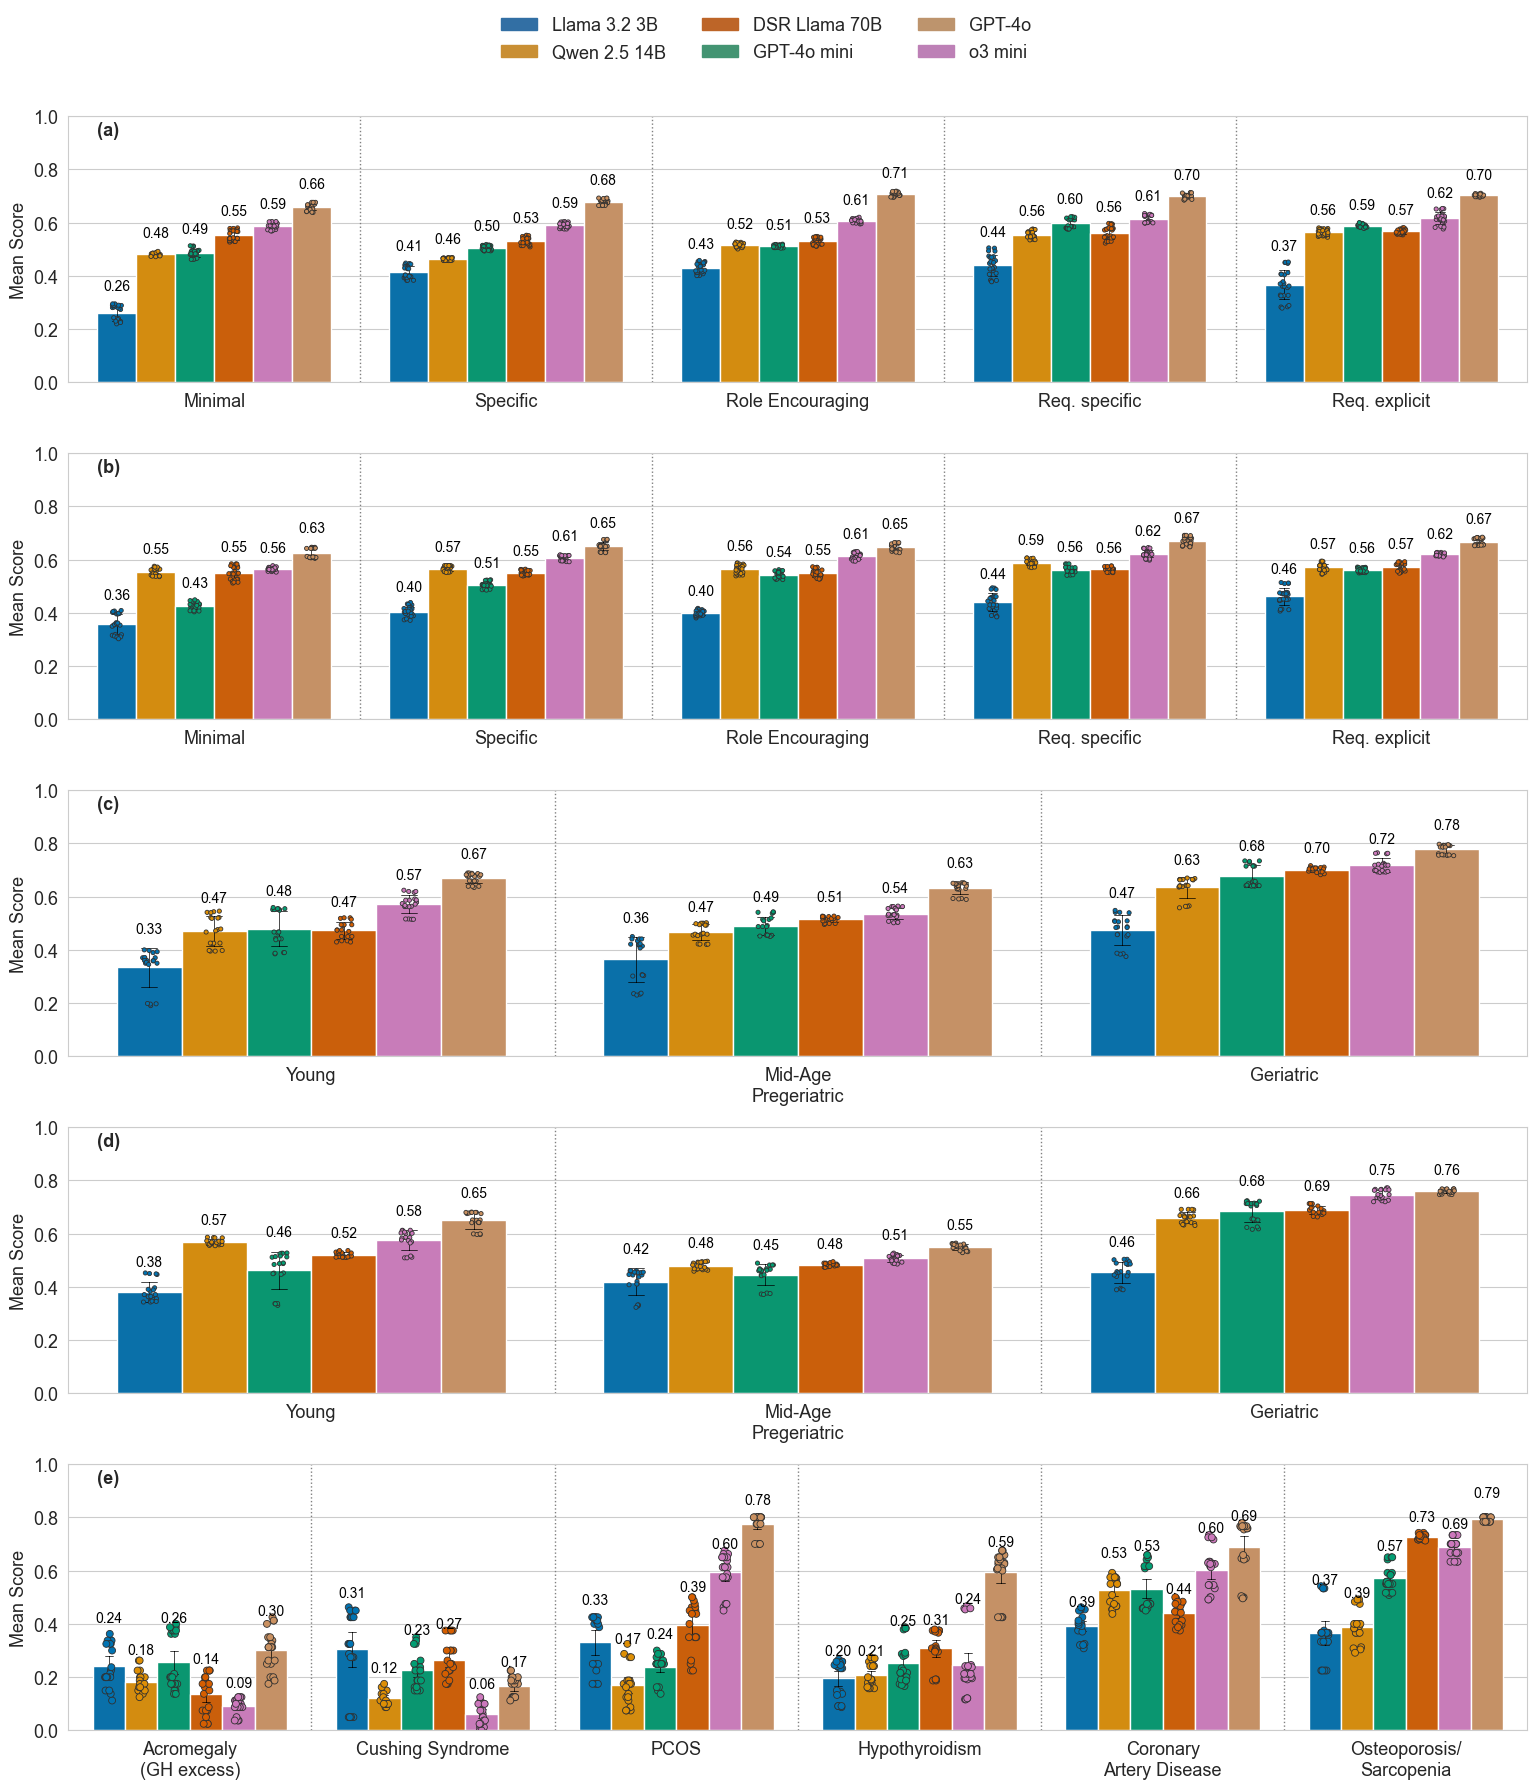

In [11]:
from cmcrameri import cm
import matplotlib.gridspec as gridspec

frames = []
for sys_prompt, pretty_prompt in prompt_mapping.items():
    dfs = []
    for subtask, pretty_subtask in subtask_mapping.items():
        df_helper = score_helper(df[(df["subtask"].str.contains(sys_prompt)) &
                                    (df["subtask"].str.contains(subtask)) &
                                    (df["subtask"].str.startswith("longevity"))])[3]
        df_helper["system_prompt"] = sys_prompt
        df_helper["subtask"] = subtask
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip = pd.concat(frames, ignore_index = True)
df_strip = map_columns(df = df_strip, model_mapping = model_mapping, prompt_mapping = prompt_mapping, subtask_mapping = subtask_mapping) 

custom_prompt_order = ["Minimal", "Specific", "Role Encouraging", "Req. specific", "Req. explicit"]
custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip["system_prompt"] = pd.Categorical(df_strip["system_prompt"], categories = custom_prompt_order, ordered = True)
df_strip["evaluated_model"] = pd.Categorical(df_strip["evaluated_model"], categories = custom_model_order, ordered = True)

sns.set_style(style = "whitegrid")

fig = plt.figure(figsize=(20, 17))
gs = gridspec.GridSpec(ncols = 8, nrows = 5, figure=fig)

axs = [
    fig.add_subplot(gs[0, 1:7]),
    fig.add_subplot(gs[1, 1:7]),
    fig.add_subplot(gs[2, 1:7]),
    fig.add_subplot(gs[3, 1:7]),
    fig.add_subplot(gs[4, 1:7]),
]

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for sys_prompt, pretty_prompt in prompt_mapping.items():
        df_helper = score_helper(df = df[
            (df["evaluated_model"] == model) &
            (df["subtask"].str.contains(sys_prompt)) &
            (df["subtask"].str.startswith("longevity"))
        ])[3].copy()
        df_helper["system_prompt"] = sys_prompt
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df = pd.concat(bplt_dfs, ignore_index = True)
bplt_df = map_columns(df = bplt_df, model_mapping = model_mapping, prompt_mapping = prompt_mapping)
bplt_df.reset_index(drop = True)

hue_order = (
    df_strip.groupby('evaluated_model')['score']
    .mean()
    .sort_values(ascending=True)
    .index
    .tolist()
)

plot = sns.barplot(
    x = "system_prompt", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[0],
)

stripplot = sns.stripplot(
    x = "system_prompt", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[0],
)

axs[0].set_ylim(0, 1.)
axs[0].set_ylabel("Mean Score", fontdict = {"fontsize": 13})
axs[0].tick_params(axis = "both", labelsize = 13)
axs[0].set_xlabel("")
axs[0].legend().set_visible(False)
axs[0].set_title("(a)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 13, fontdict = {"fontweight": "bold"})

lines = axs[0].lines
for p in axs[0].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[0].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 1:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    if i == 3:
        extra = +0.01
    elif i == 4:
        extra = +0.016
    else:
        extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[0].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 10,
            color = "black"
        )

metrics = df_strip["system_prompt"].unique() 
for j in range(len(metrics) - 1):
    axs[0].axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

frames = []
for sys_prompt, pretty_prompt in prompt_mapping.items():
    dfs = []
    for subtask, pretty_subtask in subtask_mapping.items():
        df_helper = score_helper(df[(df["subtask"].str.contains(sys_prompt)) &
                                    (df["subtask"].str.contains(subtask)) &
                                    (df["subtask"].str.startswith("rag"))])[3]
        df_helper["system_prompt"] = sys_prompt
        df_helper["subtask"] = subtask
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip_rag = pd.concat(frames, ignore_index = True)
df_strip_rag = map_columns(df = df_strip_rag, model_mapping = model_mapping, prompt_mapping = prompt_mapping, subtask_mapping = subtask_mapping) 

custom_prompt_order = ["Minimal", "Specific", "Role Encouraging", "Req. specific", "Req. explicit"]
custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip_rag["system_prompt"] = pd.Categorical(df_strip_rag["system_prompt"], categories = custom_prompt_order, ordered = True)
df_strip_rag["evaluated_model"] = pd.Categorical(df_strip_rag["evaluated_model"], categories = custom_model_order, ordered = True)

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for sys_prompt, pretty_prompt in prompt_mapping.items():
        df_helper = score_helper(df = df[
            (df["evaluated_model"] == model) &
            (df["subtask"].str.contains(sys_prompt)) &
            (df["subtask"].str.startswith("rag"))
        ])[3].copy()
        df_helper["system_prompt"] = sys_prompt
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df_rag = pd.concat(bplt_dfs, ignore_index = True)
bplt_df_rag = map_columns(df = bplt_df_rag, model_mapping = model_mapping, prompt_mapping = prompt_mapping)

plot_rag = sns.barplot(
    x = "system_prompt", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip_rag,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[1],
)

stripplot_rag = sns.stripplot(
    x = "system_prompt", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip_rag,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[1],
)

axs[1].set_ylim(0, 1.)
axs[1].set_ylabel("Mean Score", fontdict = {"fontsize": 13})
axs[1].tick_params(axis = "both", labelsize = 13)
axs[1].set_xlabel("")
axs[1].legend().set_visible(False)
axs[1].set_title("(b)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 13, fontdict = {"fontweight": "bold"})

lines = axs[1].lines
for p in axs[1].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[1].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 1:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[1].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 10,
            color = "black"
        )

metrics = df_strip["system_prompt"].unique() 
for j in range(len(metrics) - 1):
    axs[1].axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

age_groups = [
    "young",
    "mid-aged/pregeriatric",
    "geriatric",
]

latex_column_order = [
    "evaluated_model", "Correctness", "Comprehensiveness", 
    "Usefulness", "Interpr./Expl.", "Toxicity"
]

frames = []
for age_group in age_groups:
    dfs = []
    for prompt, pretty_prompt in prompt_mapping.items():
        df_helper = score_helper(df[(df["age"] == age_group) &
                                    (df["subtask"].str.contains(prompt)) &
                                    (df["subtask"].str.startswith("longevity"))])[3]
        df_helper["age_group"] = age_group
        df_helper["system_prompt"] = prompt
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip = pd.concat(frames, ignore_index = True)
df_strip = map_columns(df = df_strip, model_mapping = model_mapping, age_mapping = age_mapping, prompt_mapping = prompt_mapping) 

custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip["evaluated_model"] = pd.Categorical(df_strip["evaluated_model"], categories = custom_model_order, ordered = True)

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for age_group in age_groups:
        df_helper = score_helper(df = df[
            (df["evaluated_model"] == model) &
            (df["age"] == age_group) &
            (df["subtask"].str.startswith("longevity"))
        ])[3].copy()
        df_helper["age_group"] = age_group
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df = pd.concat(bplt_dfs, ignore_index = True)
bplt_df = map_columns(df = bplt_df, model_mapping = model_mapping, age_mapping = age_mapping)
bplt_df.reset_index(drop = True)

hue_order = (
    df_strip.groupby('evaluated_model')['score']
    .mean()
    .sort_values(ascending=True)
    .index
    .tolist()
)

plot = sns.barplot(
    x = "age_group", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[2],
)

stripplot = sns.stripplot(
    x = "age_group", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[2],
)

axs[2].set_ylim(0, 1.)
axs[2].set_ylabel("Mean Score", fontdict = {"fontsize": 13})
axs[2].tick_params(axis = "both", labelsize = 13)
axs[2].set_xlabel("")
axs[2].legend().set_visible(False)
axs[2].set_title("(c)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 13, fontdict = {"fontweight": "bold"})

lines = axs[2].lines
for p in axs[2].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[2].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 3:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    if i == 2:
        extra = +0.01
    elif i == 3:
        extra = -0.007
    elif i == 4:
        extra = -0.01
    elif i == 5:
        extra = -0.01
    else:
        extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[2].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 10,
            color = "black"
        )

metrics = df_strip["age_group"].unique() 
for j in range(len(metrics) - 1):
    axs[2].axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

frames = []
for age_group in age_groups:
    dfs = []
    for prompt, pretty_prompt in prompt_mapping.items():
        df_helper = score_helper(df[(df["age"] == age_group) &
                                    (df["subtask"].str.contains(prompt)) &
                                    (df["subtask"].str.startswith("rag"))])[3]
        df_helper["age_group"] = age_group
        df_helper["system_prompt"] = prompt
        dfs.append(df_helper)
    frames.append(pd.concat(dfs, ignore_index = True))
df_strip_rag = pd.concat(frames, ignore_index = True)
df_strip_rag = map_columns(df = df_strip_rag, model_mapping = model_mapping, age_mapping = age_mapping, prompt_mapping = prompt_mapping) 

custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "o3 mini", "GPT-4o mini"]
df_strip_rag["evaluated_model"] = pd.Categorical(df_strip_rag["evaluated_model"], categories = custom_model_order, ordered = True)

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for age_group in age_groups:
        df_helper = score_helper(df = df[
            (df["evaluated_model"] == model) &
            (df["age"] == age_group) &
            (df["subtask"].str.startswith("rag"))
        ])[3].copy()
        df_helper["age_group"] = age_group
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df_rag = pd.concat(bplt_dfs, ignore_index = True)
bplt_df_rag = map_columns(df = bplt_df_rag, model_mapping = model_mapping, age_mapping = age_mapping)
bplt_df_rag.reset_index(drop = True)

plot_rag = sns.barplot(
    x = "age_group", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip_rag,
    errorbar = ("sd"),
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[3],
)

stripplot_rag = sns.stripplot(
    x = "age_group", 
    y = "score", 
    hue = "evaluated_model",
    hue_order = hue_order,
    data = df_strip_rag,
    dodge = True,
    palette = "colorblind",
    # alpha = 0.5,
    size = 3,
    linewidth = 0.6,
    jitter = True,
    ax = axs[3],
)

axs[3].set_ylim(0, 1.)
axs[3].set_ylabel("Mean Score", fontdict = {"fontsize": 13})
axs[3].tick_params(axis = "both", labelsize = 13)
axs[3].set_xlabel("")
axs[3].legend().set_visible(False)
axs[3].set_title("(d)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 13, fontdict = {"fontweight": "bold"})

lines = axs[3].lines
for p in axs[3].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[3].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 3:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[3].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 10,
            color = "black"
        )

metrics = df_strip["age_group"].unique() 
for j in range(len(metrics) - 1):
    axs[3].axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

df_pathologies = df[df["subtask"].str.startswith("longevity")].copy()

models = [pretty_model for model, pretty_model in model_mapping.items()]

pathology_mapping = {
    "longevity:multimorbid_man": "Osteoporosis/\nSarcopenia",
    "longevity:underlying_condition_epicatechin": "Hypothyroidism",
    "longevity:underlying_condition_CR:": "Cushing Syndrome",
    "longevity:underlying_condition_CR_exercise": "Hypothyroidism",
    "longevity:hiit_rehab": "Coronary\nArtery Disease",
    "longevity:hiit_low_EF": "Coronary\nArtery Disease",
    "longevity:underlying_condition_regain_energy": "PCOS",
    "longevity:underlying_condition_CR_glucose:": "Acromegaly\n(GH excess)",
    "longevity:low_protein_diet": "Osteoporosis/\nSarcopenia",
}

dfs_pathologies = []
for task, pathology in pathology_mapping.items():
    for prompt, pretty_prompt in prompt_mapping.items():
        df_pathologies["subtask"] = df_pathologies["subtask"].apply(lambda x: pathology if task in x else x)
        dfs_pathologies.append(df_pathologies[
            (df_pathologies["subtask"] == pathology) &
            (df_pathologies["system_prompt"] == prompt)
        ])

df_all_pathologies = pd.concat(dfs_pathologies, ignore_index = True)
df_all_pathologies = map_columns(df_all_pathologies, metric_mapping = metric_mapping, model_mapping = model_mapping)

pathologies = df_all_pathologies["subtask"].unique()

helper_df = []
dfs_strip = []
for model in models:
    for pathology in pathologies:
        for prompt, pretty_prompt in prompt_mapping.items():
            frame = score_helper(df_all_pathologies[
                (df_all_pathologies["evaluated_model"] == model) &
                (df_all_pathologies["subtask"] == pathology) &
                (df_all_pathologies["system_prompt"] == prompt)
            ])[3]
            df_strip_helper = score_helper(df_all_pathologies[
                (df_all_pathologies["evaluated_model"] == model) &
                (df_all_pathologies["subtask"] == pathology) &
                (df_all_pathologies["system_prompt"] == prompt)
            ])[3]
            df_strip_helper["pathology"] = pathology
            df_strip_helper["system_prompt"] = prompt
            dfs_strip.append(df_strip_helper)

            frame["pathology"] = pathology
            frame["system_prompt"] = prompt
            helper_df.append(frame)
df_pathologies = pd.concat(helper_df, ignore_index = True)
df_strip = pd.concat(dfs_strip, ignore_index = True)

pathology_order = ["Acromegaly\n(GH excess)", "Cushing Syndrome", "PCOS", "Hypothyroidism", "Coronary\nArtery Disease", "Osteoporosis/\nSarcopenia"]
df_strip["evaluated_model"] = pd.Categorical(df_strip["evaluated_model"], categories = hue_order, ordered = True)
df_pathologies["evaluated_model"] = pd.Categorical(df_pathologies["evaluated_model"], categories = hue_order, ordered = True)
df_pathologies["pathology"] = pd.Categorical(df_pathologies["pathology"], categories = pathology_order, ordered = True)

bplt_dfs = []
for model, pretty_model in model_mapping.items():
    dfs = []
    for pathology in pathologies:
        df_helper = score_helper(df = df_all_pathologies[
            (df_all_pathologies["evaluated_model"] == pretty_model) &
            (df_all_pathologies["subtask"] == pathology)
        ])[3].copy()
        df_helper["pathology"] = pathology
        dfs.append(df_helper)
    bplt_dfs.append(pd.concat(dfs, ignore_index = True))

bplt_df = pd.concat(bplt_dfs, ignore_index = True)
bplt_df.reset_index(drop = True)

plot_pathologies = sns.barplot(
    x = "pathology", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_pathologies,
    capsize = 0.2,
    err_kws={
        "linewidth": 0.5,
        "color": "black",
    },
    palette = "colorblind", 
    saturation = 0.9,
    ax = axs[4]
)

stripplot_pathologies = sns.stripplot(
    x = "pathology", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_strip,
    dodge = True,
    palette = "colorblind", 
    # alpha = 0.5,
    linewidth = 0.6,
    jitter = True,
    ax = axs[4]
)

axs[4].set_ylim(0, 1.)
axs[4].set_ylabel("Mean Score", fontdict = {"fontsize": 13})
axs[4].tick_params(axis = "both", labelsize = 13)
axs[4].set_xlabel("")
axs[4].legend().set_visible(False)
axs[4].set_title("(e)", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 13, fontdict = {"fontweight": "bold"})

lines = axs[4].lines
for p in axs[4].lines:
        width = p.get_linewidth()
        xy = p.get_ydata()
        print(xy)
        print(width)
        print(p)

for i, patch in enumerate(axs[4].patches):
    if i < len(lines) and len(lines[i].get_ydata()) > 3:
        error_bar = lines[i]
        error_bar_height = (error_bar.get_ydata()[4] - error_bar.get_ydata()[3]) / 2
    else:
        error_bar_height = 0

    height = patch.get_height()
    if i == 0:
        extra = +0.07
    elif i == 1:
        extra = +0.07
    elif i == 2:
        extra = +0.04
    elif i == 5:
        extra = +0.08
    elif i == 6:
        extra = +0.03
    elif i == 7:
        extra = +0.03
    elif i == 8:
        extra = +0.07
    elif i == 10:
        extra = +0.04
    elif i == 11:
        extra = +0.03
    elif i == 12:
        extra = +0.05
    elif i == 13:
        extra = +0.05
    elif i == 14:
        extra = +0.03
    elif i == 15:
        extra = +0.05
    elif i == 16:
        extra = +0.05
    elif i == 17:
        extra = +0.03
    elif i == 18:
        extra = +0.03
    elif i == 19:
        extra = +0.03
    elif i == 20:
        extra = +0.03
    elif i == 25:
        extra = +0.02
    elif i == 27:
        extra = +0.13
    elif i == 28:
        extra = +0.05
    elif i == 30:
        extra = +0.04
    elif i == 35:
        extra = +0.02
    else:
        extra = 0
    print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[4].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, (patch.get_height() + error_bar_height) + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 10,
            color = "black"
        )

for j in range(len(pathologies) - 1):
    plot_pathologies.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

import matplotlib.patches as mpatches
llama_patch = mpatches.Patch(color= (50/255, 111/255, 164/255), label='Llama 3.2 3B')
qwen_patch = mpatches.Patch(color=(201/255, 143/255, 52/255), label='Qwen 2.5 14B')
dsr_patch = mpatches.Patch(color=(189/255, 101/255, 40/255), label='DSR Llama 70B')
gpt_4omini_patch = mpatches.Patch(color=(67/255, 148/255, 114/255), label='GPT-4o mini')
gpt_4o_patch = mpatches.Patch(color=(189/255, 148/255, 109/255), label='GPT-4o')
o3mini_patch = mpatches.Patch(color=(189/255, 128/255, 182/255), label='o3 mini')

fig.legend(
    handles=[llama_patch, 
             qwen_patch,
             dsr_patch,
             gpt_4omini_patch,
             gpt_4o_patch,
             o3mini_patch
    ],
    # loc='outside upper center',
    bbox_to_anchor = (0.62, 1.05),
    ncols = len(df_strip["evaluated_model"].unique()) / 2,
    frameon = False,
    borderaxespad = 0.,
    fontsize = 13,
)

plt.tight_layout()

# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/figure_3.pdf", dpi = 300, bbox_inches = "tight")
gs.tight_layout(fig)
plt.show()

In [12]:
df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")
df_x = df.copy()
models = df_x["evaluated_model"].unique()
metrics = df_x["metric"].unique()

prompts = [prompt for prompt in df_x["system_prompt"].unique()]

frame = {}
for model in models:
    print(f"\033[1;4;32m{model_mapping[model]}\033[0m")
    frame[model] = {}
    for metric in metrics:
        frame[model][metric] = {}
        for prompt in prompts:
            helper_frame = df_x[
                (df_x["evaluated_model"] == model) &
                (df_x["metric"] == metric) &
                (df_x["system_prompt"] == prompt) &
                (df_x["subtask"].str.startswith("longevity"))
            ].copy().reset_index(drop = True)
            helper_frame["binary_rating"] = helper_frame["rating"].apply(process_rating)
            frame[model][metric]["id"] = [id for id in range(len(helper_frame))]
            frame[model][metric][prompt] = list(helper_frame["binary_rating"])

        data_wide = pd.DataFrame(frame[model][metric])
        data_long = data_wide.melt(id_vars = ["id"], var_name = "prompt", value_name = "score")
        q = pg.cochran(data = data_long, dv = "score", within = "prompt", subject = "id")["Q"].iloc[0]
        p_value = pg.cochran(data = data_long, dv = "score", within = "prompt", subject = "id")["p-unc"].iloc[0]

        print(f"\033[1m{metric_mapping[metric]}:\033[0m")
        print(f"Q-value: {q}")
        print(f"p-value: {p_value}")
        print("")

        for i in range(len(prompts) - 1):
            for j in range(i + 1, len(prompts)):
                print(f"\033[3m{prompt_mapping[prompts[i]]} vs {prompt_mapping[prompts[j]]}\033[0m")

                subset = data_wide[[prompts[i], prompts[j]]]
                b = sum((subset[prompts[i]] == 0) & (subset[prompts[j]] == 1))
                c = sum((subset[prompts[i]] == 1) & (subset[prompts[j]] == 0))
                
                if b == 0 and c == 0:
                    print(f"\033[1;31mSkipping {prompts[i]} vs {prompts[j]} (No discordant pairs)\033[0m")
                    print("")
                    continue

                chi2 = pg.chi2_mcnemar(data = data_wide[[prompts[i], prompts[j]]], x = prompts[i], y = prompts[j])[1]["chi2"].iloc[0]
                p_value = pg.chi2_mcnemar(data = data_wide[[prompts[i], prompts[j]]], x = prompts[i], y = prompts[j])[1]["p-approx"].iloc[0]

                print(f"chi2: {chi2}")
                print(f"p-value: {p_value * 10}")
                print("")

DSR Llama 70B
Comprehensiveness:
Q-value: 22.583333333333332
p-value: 0.0001533565216125966

Minimal vs Req. explicit
chi2: 0.5208333333333334
p-value: 4.704864220587895

Minimal vs Req. specific
chi2: 2.4390243902439024
p-value: 1.1834981273562868

Minimal vs Role Encouraging
chi2: 1.3617021276595744
p-value: 2.4324270574265348

Minimal vs Specific
chi2: 6.568181818181818
p-value: 0.10381795789701763

Req. explicit vs Req. specific
chi2: 0.3404255319148936
p-value: 5.595836997752427

Req. explicit vs Role Encouraging
chi2: 3.69811320754717
p-value: 0.5447403510619565

Req. explicit vs Specific
chi2: 10.58
p-value: 0.011431765973566505

Req. specific vs Role Encouraging
chi2: 6.446428571428571
p-value: 0.11117560716107

Req. specific vs Specific
chi2: 16.0
p-value: 0.000633424836662399

Role Encouraging vs Specific
chi2: 1.4222222222222223
p-value: 2.3303798227390207

Correctness:
Q-value: 6.333333333333333
p-value: 0.17559934795531829

Minimal vs Req. explicit
chi2: 0.6956521739130435

In [13]:
df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")
df_x = df

models = [model for model, pretty_model in model_mapping.items()]

final_frame = {}
for age_group, pretty_age in age_mapping.items():
    for model in models:
        helper_frame = df_x[(df_x["evaluated_model"] == model) &
                            (df_x["subtask"].str.startswith("longevity")) &
                            (df_x["age"] == age_group)].copy()
        helper_frame["binary_rating"] = helper_frame["rating"].apply(process_rating)
        final_frame[model] = list(helper_frame["binary_rating"])

    data = pd.DataFrame(final_frame)
    keys = list(final_frame.keys())

    print(f"\033[1m{pretty_age}\033[0m")
    for i in range(len(models) - 1):
        for j in range(i + 1, len(models)):
            chi2 = pg.chi2_mcnemar(data = data, x = models[i], y = models[j])[1]["chi2"].iloc[0]
            p_value = pg.chi2_mcnemar(data = data, x = models[i], y = models[j])[1]["p-approx"].iloc[0]

            print(f"{model_mapping[models[i]]} vs {model_mapping[models[j]]}")
            print(f"chi2: {chi2}")
            print(f"p-value: {p_value * 15}")
            print("")

Young
Llama 3.2 3B vs Qwen 2.5 14B
chi2: 103.18549511854951
p-value: 4.577885862188507e-23

Llama 3.2 3B vs DSR Llama 70B
chi2: 119.20544217687075
p-value: 1.416382594501181e-26

Llama 3.2 3B vs GPT-4o
chi2: 556.1372745490982
p-value: 8.729475030018327e-122

Llama 3.2 3B vs GPT-4o mini
chi2: 118.34626436781609
p-value: 2.1842082150848794e-26

Llama 3.2 3B vs o3 mini
chi2: 312.6282485875706
p-value: 8.765513290930954e-69

Qwen 2.5 14B vs DSR Llama 70B
chi2: 0.9280701754385965
p-value: 5.030473370360696

Qwen 2.5 14B vs GPT-4o
chi2: 315.1117397454031
p-value: 2.5222416611384184e-69

Qwen 2.5 14B vs GPT-4o mini
chi2: 0.4109014675052411
p-value: 7.822684655416375

Qwen 2.5 14B vs o3 mini
chi2: 112.6919014084507
p-value: 3.7807472855256585e-25

DSR Llama 70B vs GPT-4o
chi2: 328.48445171849426
p-value: 3.082970179829989e-72

DSR Llama 70B vs GPT-4o mini
chi2: 0.13034623217922606
p-value: 10.771099850243672

DSR Llama 70B vs o3 mini
chi2: 95.69525547445255
p-value: 2.010018147086173e-21

GPT-

## Supplementary Appendix H
#### Supplementary Figure H1

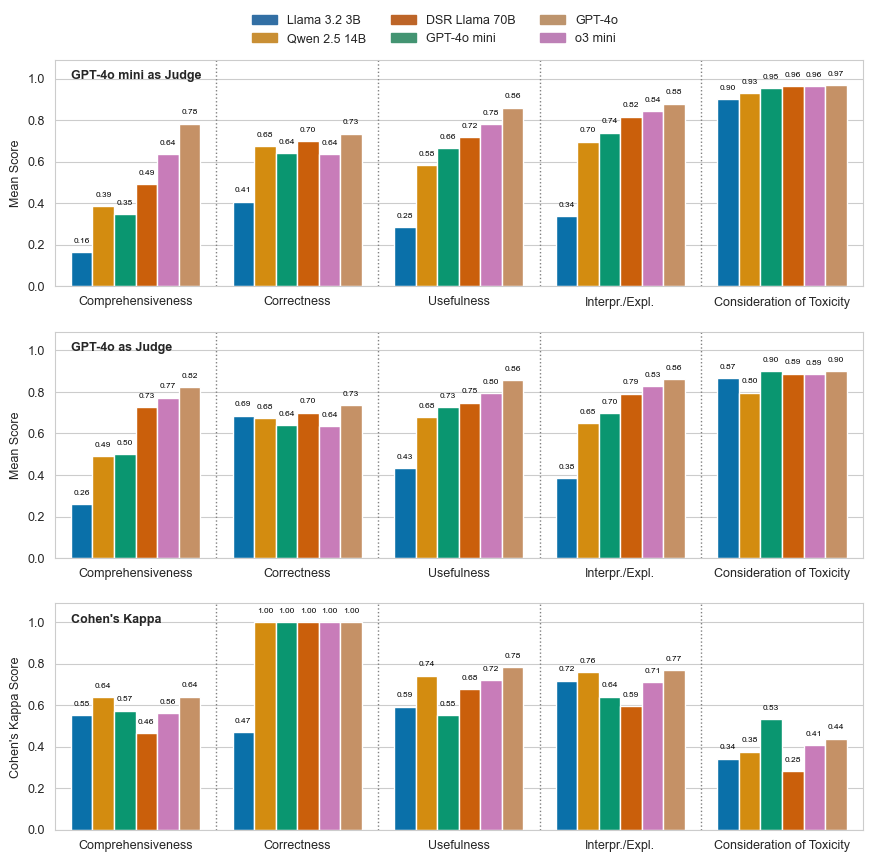

In [14]:
gpt_4o_only = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses_gpt_4o.csv")

import matplotlib.gridspec as gridspec

dfs_gpt_4o = []
dfs_gpt_4o_mini = []
for metric, pretty_metric in metric_mapping.items():
    helper_gpt_4o = score_helper(gpt_4o_only[
        (gpt_4o_only["metric"] == metric)
    ])[2]
    helper_gpt_4o_mini = score_helper(df[
        (df["metric"] == metric) &
        (df["subtask"].str.contains("minimal")) &
        (df["subtask"].str.startswith("longevity"))
    ])[2]
    helper_gpt_4o["metric"] = metric
    helper_gpt_4o_mini["metric"] = metric

    dfs_gpt_4o.append(helper_gpt_4o)
    dfs_gpt_4o_mini.append(helper_gpt_4o_mini)

df_gpt_4o = pd.concat(dfs_gpt_4o, ignore_index = True)
df_gpt_4o_mini = pd.concat(dfs_gpt_4o_mini, ignore_index = True)

df_gpt_4o = map_columns(df = df_gpt_4o, metric_mapping = metric_mapping, model_mapping = model_mapping)
df_gpt_4o_mini = map_columns(df = df_gpt_4o_mini, metric_mapping = metric_mapping, model_mapping = model_mapping)

custom_metric_order = ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"]
df_gpt_4o["metric"] = pd.Categorical(df_gpt_4o["metric"], categories = custom_metric_order, ordered = True)
df_gpt_4o_mini["metric"] = pd.Categorical(df_gpt_4o_mini["metric"], categories = custom_metric_order, ordered = True)

hue_order = (
    df_gpt_4o_mini.groupby('evaluated_model')['score']
    .mean()
    .sort_values(ascending=True)
    .index
    .tolist()
)

df_gpt_4o["evaluated_model"] = pd.Categorical(df_gpt_4o["evaluated_model"], categories = hue_order, ordered = True)
df_gpt_4o_mini["evaluated_model"] = pd.Categorical(df_gpt_4o_mini["evaluated_model"], categories = hue_order, ordered = True)

df_gpt_4o = df_gpt_4o.reset_index(drop = True)
df_gpt_4o.loc[df_gpt_4o["metric"] == "Consideration of Toxicity", "score"] = 1 - df_gpt_4o["score"]

df_gpt_4o_mini = df_gpt_4o_mini.reset_index(drop = True)
df_gpt_4o_mini.loc[df_gpt_4o_mini["metric"] == "Consideration of Toxicity", "score"] = 1 - df_gpt_4o_mini["score"]

sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
# fig, ax = plt.subplots(figsize=(12, 6))

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(ncols = 8, nrows = 3, figure = fig)

axs = [
    fig.add_subplot(gs[0, 1:7]),
    fig.add_subplot(gs[1, 1:7]),
    fig.add_subplot(gs[2, 1:7]),
]

plot_gpt_4o_mini = sns.barplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_gpt_4o_mini,
    errorbar = None,
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[0]
)

axs[0].legend().set_visible(False)
axs[0].set_ylabel("Mean Score", fontsize = 9)
axs[0].set_ylim(0, 1.09)
axs[0].set_xlabel("")
axs[0].tick_params(axis = "both", labelsize = 9)
axs[0].set_xticks(np.arange(5), ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"])
axs[0].set_title("GPT-4o mini as Judge", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

for i, patch in enumerate(axs[0].patches):
    height = patch.get_height()
    extra = -0.02
    if patch.get_height() > 0:
        axs[0].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, patch.get_height() + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

metrics = df_gpt_4o_mini["metric"].unique() 
for j in range(len(metrics) - 1):
    plot_gpt_4o_mini.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

plot_gpt_4o = sns.barplot(
    x = "metric", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_gpt_4o,
    errorbar = None,
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[1]
)

axs[1].legend().set_visible(False)
axs[1].set_ylabel("Mean Score", fontsize = 9)
axs[1].set_ylim(0, 1.09)
axs[1].set_xlabel("")
axs[1].tick_params(axis = "both", labelsize = 9)
axs[1].set_xticks(np.arange(5), ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"])
axs[1].set_title("GPT-4o as Judge", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

for i, patch in enumerate(axs[1].patches):
    height = patch.get_height()
    extra = -0.02
    if patch.get_height() > 0:
        axs[1].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, patch.get_height() + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

metrics = df_gpt_4o["metric"].unique() 
for j in range(len(metrics) - 1):
    plot_gpt_4o.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

from sklearn.metrics import cohen_kappa_score

interrater_frame = {
    "evaluated_model": [],
    "metric": [],
    "kappa_score": [],
}

for metric in gpt_4o_only["metric"].unique().tolist():
    for model in gpt_4o_only["evaluated_model"].unique().tolist():
        sub_gpt_4o_only = score_helper(gpt_4o_only[
            (gpt_4o_only["evaluated_model"] == model) &
            (gpt_4o_only["metric"] == metric)
        ])[0].copy().reset_index(drop = True)

        sub_df = score_helper(df[
            (df["evaluated_model"] == model) &
            (df["metric"] == metric) &
            (df["subtask"].str.contains("minimal")) &
            (df["subtask"].str.startswith("longevity"))
        ])[0].copy().reset_index(drop = True)

        if metric == "toxicity":
            sub_gpt_4o_only["iteration_scores"] = sub_gpt_4o_only["iteration_scores"].apply(lambda x: False if x == 1.0 else True)
            sub_df["iteration_scores"] = sub_df["iteration_scores"].apply(lambda x: False if x == 1.0 else True)
        else:
            sub_gpt_4o_only["iteration_scores"] = sub_gpt_4o_only["iteration_scores"].apply(lambda x: True if x == 1.0 else False)
            sub_df["iteration_scores"] = sub_df["iteration_scores"].apply(lambda x: True if x == 1.0 else False)

        kappa = cohen_kappa_score(sub_gpt_4o_only["iteration_scores"], sub_df["iteration_scores"])

        interrater_frame["evaluated_model"].append(model)
        interrater_frame["metric"].append(metric)
        interrater_frame["kappa_score"].append(kappa)

interrater_df = pd.DataFrame(interrater_frame)
interrater_df = map_columns(df = interrater_df, model_mapping = model_mapping, metric_mapping = metric_mapping)
interrater_df["metric"] = pd.Categorical(interrater_df["metric"], categories = custom_metric_order, ordered = True)
interrater_df["evaluated_model"] = pd.Categorical(interrater_df["evaluated_model"], categories = hue_order, ordered = True)

plot_kappa = sns.barplot(
    data = interrater_df, 
    x = "metric", 
    y = "kappa_score",
    hue = "evaluated_model",
    errorbar = None,
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[2]
)

axs[2].legend().set_visible(False)
axs[2].set_ylabel("Cohen's Kappa Score", fontsize = 9)
axs[2].set_ylim(0, 1.09)
axs[2].set_xlabel("")
axs[2].tick_params(axis = "both", labelsize = 9)
axs[2].set_xticks(np.arange(5), ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"])
axs[2].set_title("Cohen's Kappa", loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

for i, patch in enumerate(axs[2].patches):
    height = patch.get_height()
    extra = -0.02
    # print(f"Bar {i + 1}: Height = {height:.4f}, Std = {error_bar_height:.4f}")
    if patch.get_height() > 0:
        axs[2].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, patch.get_height() + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

metrics = df_gpt_4o["metric"].unique() 
for j in range(len(metrics) - 1):
    plot_kappa.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

import matplotlib.patches as mpatches
llama_patch = mpatches.Patch(color= (50/255, 111/255, 164/255), label='Llama 3.2 3B')
qwen_patch = mpatches.Patch(color=(201/255, 143/255, 52/255), label='Qwen 2.5 14B')
dsr_patch = mpatches.Patch(color=(189/255, 101/255, 40/255), label='DSR Llama 70B')
gpt_4omini_patch = mpatches.Patch(color=(67/255, 148/255, 114/255), label='GPT-4o mini')
gpt_4o_patch = mpatches.Patch(color=(189/255, 148/255, 109/255), label='GPT-4o')
o3mini_patch = mpatches.Patch(color=(189/255, 128/255, 182/255), label='o3 mini')

fig.legend(
    handles=[llama_patch, 
             qwen_patch,
             dsr_patch,
             gpt_4omini_patch,
             gpt_4o_patch,
             o3mini_patch
    ],
    bbox_to_anchor = (0.63, 0.93),
    ncols = len(df_gpt_4o_mini["evaluated_model"].unique()) / 2,
    frameon = False,
    borderaxespad = 0.,
    fontsize = 9,
)

# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/supplementary_figure_h2.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

#### Supplementary Figure H2

In [15]:
import os

dfs = []

path = "/Users/u018480/Desktop/Projects/biochatter/benchmark/results/"
files = []
for file in os.listdir(path):
    if (not file.startswith((".", "only")) and file.endswith("_response.csv")):
        files.append(file)

pattern = r"final answer:\s*(yes|no)"
def clean_responses(responses):
    return re.sub(r"</?think>|[\*#]+", "", responses)

for file in files:
    x = pd.read_csv(f"{path}{file}")
    x["response"] = x["response"].apply(ast.literal_eval)

    scores = []
    frame = {}
    for i, responses in enumerate(x["response"].tolist()):
        sub_scores = []
        for response in responses:
            cleaned_response = clean_responses(response.lower())
            matches = re.findall(pattern, cleaned_response)
            final_response = [re.sub(r"[\*\s]+", "", match) for match in matches]

            if final_response == []:
                sub_scores.append("0")
            elif final_response[0] == x["expected_answer"].tolist()[i].lower():
                sub_scores.append("1")
            else:
                sub_scores.append("0")
        scores.append(sub_scores)
    
    score_strings = []
    for i, score in enumerate(scores):
        score_strings.append(";".join(score))

    frame = {
        "evaluated_model": x["model_name"].tolist(),
        "subtask": x["subtask"].tolist(),
        "iterations": 2,
        "rating": [f"{score_string}/{1}" for score_string in score_strings],
    }

    evaluation_frame = pd.DataFrame(frame)
    dfs.append(evaluation_frame)

final_evaluation_correctness = pd.concat(dfs, ignore_index = True) 

/var/folders/g2/71rvhczs5jz338chhbpn8yh1w8w73f/T/ipykernel_3208/2831637343.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_gpt_4o_mini.groupby('evaluated_model')['score']


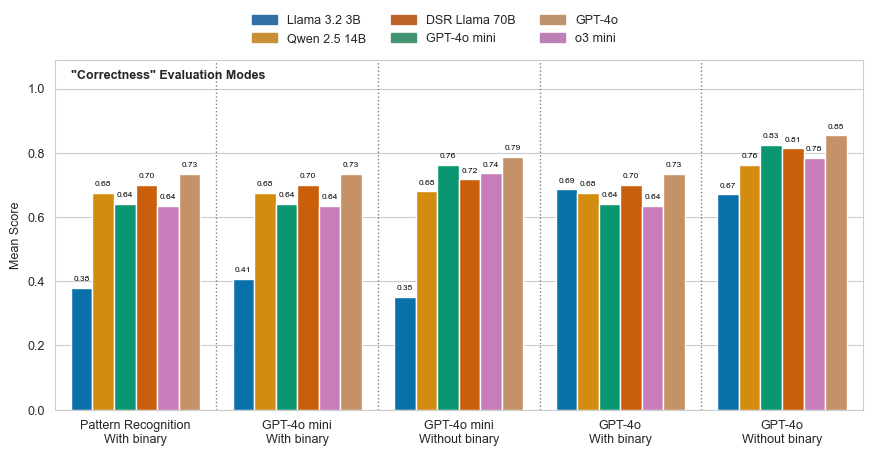

In [16]:
only_correctness = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses_only_correctness.csv")

metric = "correctness"

df_gpt_4o_binary = score_helper(gpt_4o_only[
    (gpt_4o_only["metric"] == metric)
])[2]
df_gpt_4o_binary["metric"] = metric
df_gpt_4o_binary["mode"] = "gpt_4o_binary"

df_gpt_4o_mini_binary = score_helper(df[
    (df["metric"] == metric) &
    (df["subtask"].str.contains("minimal")) &
    (df["subtask"].str.startswith("longevity"))
])[2]
df_gpt_4o_mini_binary["metric"] = metric
df_gpt_4o_mini_binary["mode"] = "gpt_4o_mini_binary"

df_binary_patterns = score_helper(final_evaluation_correctness[
    (final_evaluation_correctness["subtask"].str.contains("minimal"))
])[2]
df_binary_patterns["metric"] = metric
df_binary_patterns["mode"] = "binary_patterns"

df_gpt_4o_none = score_helper(only_correctness[
    (only_correctness["model_name"] == "gpt-4o-2024-11-20")
])[2]
df_gpt_4o_none["metric"] = metric
df_gpt_4o_none["mode"] = "none_gpt_4o"

df_gpt_4o_mini_none = score_helper(only_correctness[
    (only_correctness["model_name"] == "gpt-4o-mini-2024-07-18")
])[2]
df_gpt_4o_mini_none["metric"] = metric
df_gpt_4o_mini_none["mode"] = "none_gpt_4o_mini"

df_correctness = pd.concat(
    [df_binary_patterns, df_gpt_4o_mini_binary, df_gpt_4o_mini_none, df_gpt_4o_binary, df_gpt_4o_none],
    ignore_index = True,
)

df_correctness = map_columns(df = df_correctness, metric_mapping = metric_mapping, model_mapping = model_mapping)

hue_order = (
    df_gpt_4o_mini.groupby('evaluated_model')['score']
    .mean()
    .sort_values(ascending=True)
    .index
    .tolist()
)

df_correctness["evaluated_model"] = pd.Categorical(df_correctness["evaluated_model"], categories = hue_order, ordered = True)

sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
# fig, ax = plt.subplots(figsize=(12, 6))

fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(ncols = 8, nrows = 2, figure=fig)

axs = [
    fig.add_subplot(gs[0, 1:7]),
]

plot_correctness = sns.barplot(
    x = "mode", 
    y = "score", 
    hue = "evaluated_model", 
    data = df_correctness,
    errorbar = None,
    palette = "colorblind", 
    saturation = 0.9,
    width = 0.8,
    ax = axs[0]
)

axs[0].legend().set_visible(False)
axs[0].set_ylabel("Mean Score", fontsize = 9)
axs[0].set_ylim(0, 1.09)
axs[0].set_xlabel("")
axs[0].tick_params(axis = "both", labelsize = 9)
axs[0].set_xticks(np.arange(5), ["Pattern Recognition\nWith binary", 
                                 "GPT-4o mini\nWith binary", 
                                 "GPT-4o mini\nWithout binary", 
                                 "GPT-4o\nWith binary",
                                 "GPT-4o\nWithout binary"])
axs[0].set_title('"Correctness" Evaluation Modes', loc = "left", y = 1.0, x = 0.02, pad=-14, fontsize = 9, fontdict = {"fontweight": "bold"})

for i, patch in enumerate(axs[0].patches):
    height = patch.get_height()
    extra = -0.02
    if patch.get_height() > 0:
        axs[0].annotate(
            format(patch.get_height(), ".2f"),
            (patch.get_x() + patch.get_width() / 2, patch.get_height() + extra),
            ha = "center",
            va = "bottom",
            xytext = (0, 9),
            textcoords = "offset points",
            fontsize = 6,
            color = "black"
        )

metrics = df_correctness["mode"].unique() 
for j in range(len(metrics) - 1):
    plot_correctness.axvline(x=j + 0.5, color="gray", linestyle=":", linewidth=1)

import matplotlib.patches as mpatches
llama_patch = mpatches.Patch(color= (50/255, 111/255, 164/255), label='Llama 3.2 3B')
qwen_patch = mpatches.Patch(color=(201/255, 143/255, 52/255), label='Qwen 2.5 14B')
dsr_patch = mpatches.Patch(color=(189/255, 101/255, 40/255), label='DSR Llama 70B')
gpt_4omini_patch = mpatches.Patch(color=(67/255, 148/255, 114/255), label='GPT-4o mini')
gpt_4o_patch = mpatches.Patch(color=(189/255, 148/255, 109/255), label='GPT-4o')
o3mini_patch = mpatches.Patch(color=(189/255, 128/255, 182/255), label='o3 mini')

fig.legend(
    handles=[llama_patch, 
             qwen_patch,
             dsr_patch,
             gpt_4omini_patch,
             gpt_4o_patch,
             o3mini_patch
    ],
    bbox_to_anchor = (0.63, 0.93),
    ncols = len(df_correctness["evaluated_model"].unique()) / 2,
    frameon = False,
    borderaxespad = 0.,
    fontsize = 9,
)

# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/supplementary_figure_h1.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Supplementary Appendix K
#### Supplementary Tables K1 + K3

In [17]:
sys_prompts = list(prompt_mapping.keys())

dfs = []
for sys_prompt in sys_prompts:
    df_helper = score_helper(df[
        (df["system_prompt"] == sys_prompt) & 
        (df["subtask"].str.startswith("rag"))
    ])[3]
    df_helper["system_prompt"] = sys_prompt
    
    dfs.append(df_helper)

df_sys_prompts = pd.concat(dfs, ignore_index = True)
df_sys_prompts = map_columns(df = df_sys_prompts, prompt_mapping = prompt_mapping, model_mapping = model_mapping)

custom_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "GPT-4o mini", "o3 mini"]
df_sys_prompts["evaluated_model"] = pd.Categorical(df_sys_prompts["evaluated_model"], categories = custom_order, ordered = True)

latex_column_order = [
    "evaluated_model", "Minimal", "Specific", "Role Encouraging", 
    "Req. specific", "Req. explicit",
]

latex_df = (
    df_sys_prompts.groupby(['evaluated_model', 'system_prompt'], observed = False)['score']
    .mean()
    .unstack('system_prompt')
    .reindex(columns=["Minimal", "Specific", "Role Encouraging", "Req. specific", "Req. explicit"])
    .reset_index()
)
latex_df = latex_df[latex_column_order]
latex_df = latex_df.to_latex(index = False, float_format = "%.2f")
print(latex_df)

\begin{tabular}{lrrrrr}
\toprule
evaluated_model & Minimal & Specific & Role Encouraging & Req. specific & Req. explicit \\
\midrule
Llama 3.2 3B & 0.36 & 0.37 & 0.40 & 0.44 & 0.46 \\
Qwen 2.5 14B & 0.55 & 0.54 & 0.56 & 0.59 & 0.57 \\
DSR Llama 70B & 0.55 & 0.54 & 0.55 & 0.56 & 0.57 \\
GPT-4o & 0.63 & 0.63 & 0.65 & 0.67 & 0.67 \\
GPT-4o mini & 0.43 & 0.45 & 0.54 & 0.56 & 0.56 \\
o3 mini & 0.56 & 0.59 & 0.61 & 0.62 & 0.62 \\
\bottomrule
\end{tabular}



#### Supplementary Figure K1 + K2, Supplementary Tables K2 + K4

In [18]:
def create_sysprompt_frame(dfs, sys_prompts, metrics, task_type):
    sys_prompt_df_std, sys_prompt_df_val = [], []

    for df in dfs:
        sys_prompt_frame_std, sys_prompt_frame_val = [], []

        for sys_prompt, metric in [(s, m) for s in sys_prompts for m in metrics]:
            df_helper = df[(df["metric"] == metric) &
                           (df["subtask"].str.startswith(task_type)) &
                           (df["system_prompt"] == sys_prompt)]
            
            _std, _val = score_helper(df_helper)[2:4]

            _std["metric"], _std["system_prompt"] = metric, sys_prompt
            _val["metric"], _val["system_prompt"] = metric, sys_prompt

            sys_prompt_frame_std.append(_std)
            sys_prompt_frame_val.append(_val)

        sys_prompt_df_std.append(pd.concat(sys_prompt_frame_std))
        sys_prompt_df_val.append(pd.concat(sys_prompt_frame_val))
    return (sys_prompt_df_std, sys_prompt_df_val)

dfs = create_frames(df = df)
sys_prompt_dfs_std, sys_prompt_dfs_val = create_sysprompt_frame(
    dfs = dfs,
    sys_prompts = [
        "minimal",
        "specific",
        "role_encouraging",
        "requirements_specific",
        "requirements_explicit",
    ],
    metrics = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    task_type = "rag",
)

Bar 1: Height = 0.1812, Std = 0.0052
Bar 2: Height = 0.6244, Std = 0.0014
Bar 3: Height = 0.3856, Std = 0.0038
Bar 4: Height = 0.4519, Std = 0.0063
Bar 5: Height = 0.8588, Std = 0.0032
Bar 6: Height = 0.1744, Std = 0.0012
Bar 7: Height = 0.6231, Std = 0.0059
Bar 8: Height = 0.4012, Std = 0.0032
Bar 9: Height = 0.4537, Std = 0.0078
Bar 10: Height = 0.8063, Std = 0.0078
Bar 11: Height = 0.2575, Std = 0.0020
Bar 12: Height = 0.6125, Std = 0.0029
Bar 13: Height = 0.4581, Std = 0.0031
Bar 14: Height = 0.5275, Std = 0.0089
Bar 15: Height = 0.8562, Std = 0.0052
Bar 16: Height = 0.3063, Std = 0.0000
Bar 17: Height = 0.6350, Std = 0.0060
Bar 18: Height = 0.5325, Std = 0.0074
Bar 19: Height = 0.6181, Std = 0.0031
Bar 20: Height = 0.8912, Std = 0.0048
Bar 21: Height = 0.3550, Std = 0.0000
Bar 22: Height = 0.6750, Std = 0.0020
Bar 23: Height = 0.5256, Std = 0.0052
Bar 24: Height = 0.6300, Std = 0.0061
Bar 25: Height = 0.8775, Std = 0.0020
Bar 1: Height = 0.5306, Std = 0.0000
Bar 2: Height = 0.7000

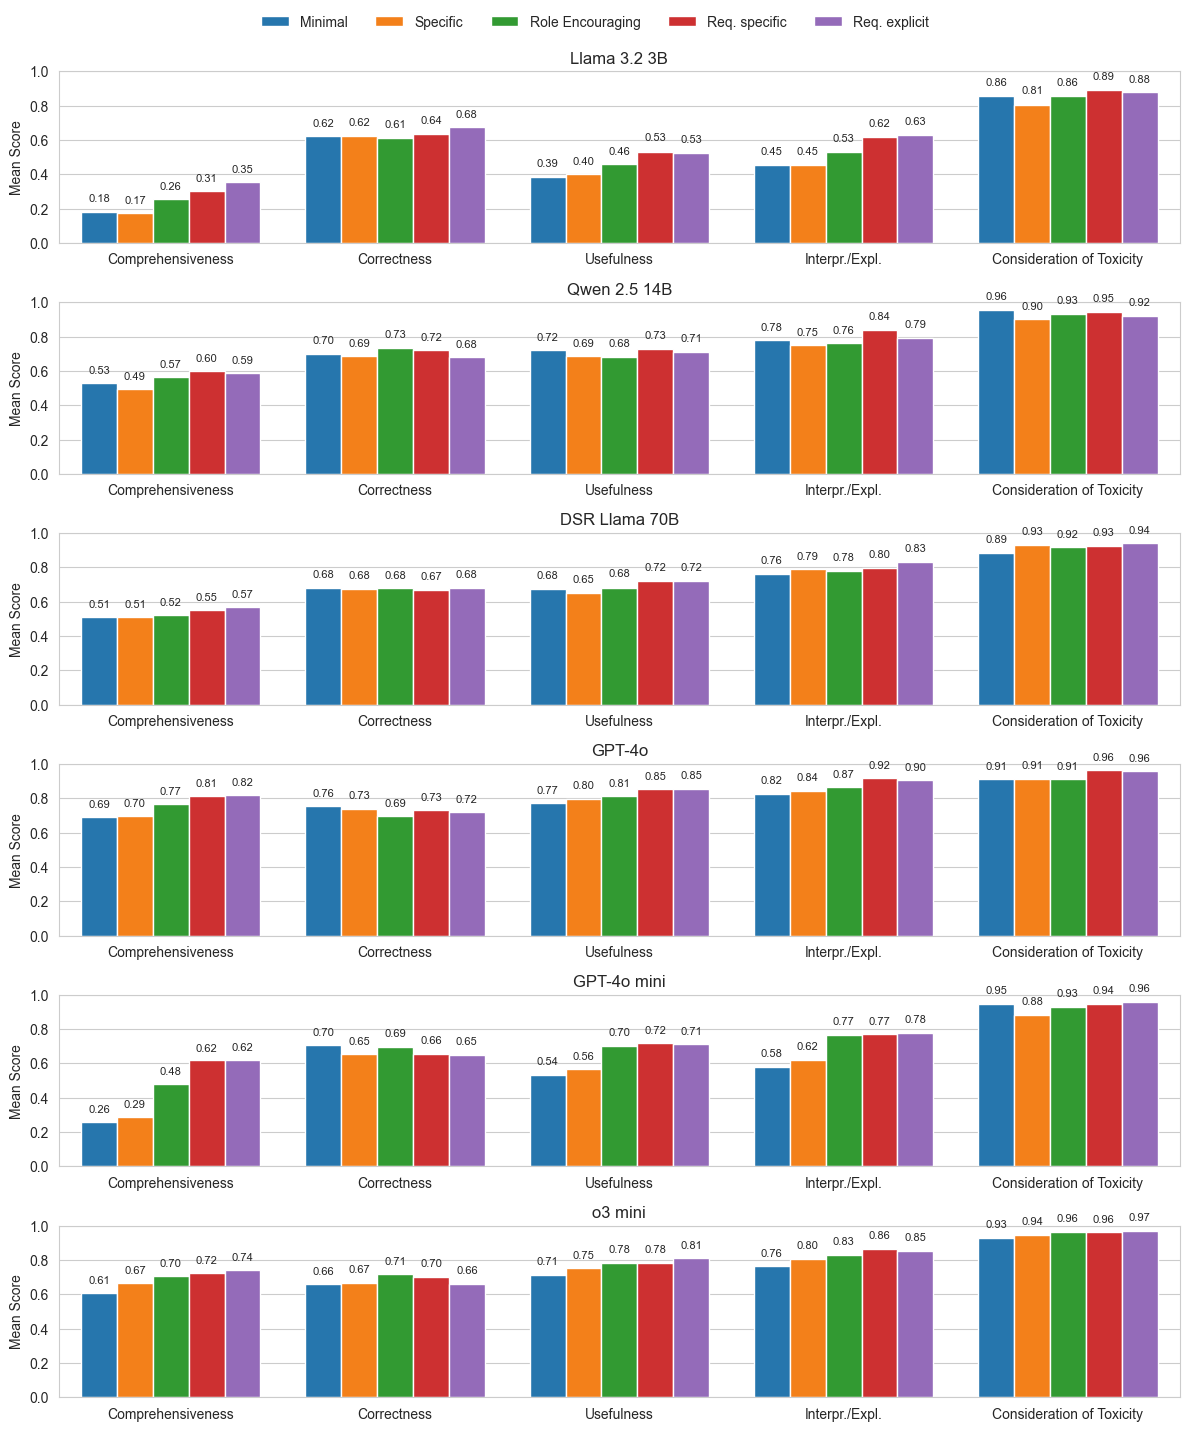

\begin{tabular}{llccccc}
\toprule
evaluated_model & system_prompt & Correctness & Comprehensiveness & Interpr./Expl. & Usefulness & Consideration of Toxicity \\
\midrule
\multirow{5}{*}{Llama 3.2 3B} & Minimal & 0.62 & 0.18 & 0.45 & 0.39 & 0.86 \\
 & Specific & 0.62 & 0.17 & 0.45 & 0.40 & 0.81 \\
 & Role Encouraging & 0.61 & 0.26 & 0.53 & 0.46 & 0.86 \\
 & Req. specific & 0.64 & 0.31 & 0.62 & 0.53 & 0.89 \\
 & Req. explicit & 0.68 & 0.35 & 0.63 & 0.53 & 0.88 \\
\multirow{5}{*}{Qwen 2.5 14B} & Minimal & 0.70 & 0.53 & 0.78 & 0.72 & 0.96 \\
 & Specific & 0.69 & 0.49 & 0.75 & 0.69 & 0.90 \\
 & Role Encouraging & 0.73 & 0.57 & 0.76 & 0.68 & 0.93 \\
 & Req. specific & 0.72 & 0.60 & 0.84 & 0.73 & 0.95 \\
 & Req. explicit & 0.68 & 0.59 & 0.79 & 0.71 & 0.92 \\
\multirow{5}{*}{DSR Llama 70B} & Minimal & 0.68 & 0.51 & 0.76 & 0.68 & 0.89 \\
 & Specific & 0.68 & 0.51 & 0.79 & 0.65 & 0.93 \\
 & Role Encouraging & 0.68 & 0.52 & 0.78 & 0.68 & 0.92 \\
 & Req. specific & 0.67 & 0.55 & 0.80 & 0.72 & 0.93

/var/folders/g2/71rvhczs5jz338chhbpn8yh1w8w73f/T/ipykernel_3208/3494830752.py:98: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latex_df['evaluated_model'] = latex_df.groupby('evaluated_model')['evaluated_model'].transform(


In [19]:
sns.set_style(style = "whitegrid")

fig, axes = plt.subplots(6, 1, figsize = (12, 14))

x = pd.concat(sys_prompt_dfs_std, ignore_index = True)
custom_metric_order = ["comprehensiveness", "correctness", "usefulness", "interpretability_explainability", "toxicity"]
custom_order = [model for model, pretty_model in model_mapping.items()]
x["evaluated_model"] = pd.Categorical(x["evaluated_model"], categories = custom_order, ordered = True)
x["metric"] = pd.Categorical(x["metric"], categories = custom_metric_order, ordered = True)
df_list = [g for b, g in x.groupby(["evaluated_model"], observed = False)]

x = pd.concat(sys_prompt_dfs_val, ignore_index = True)
x["evaluated_model"] = pd.Categorical(x["evaluated_model"], categories = custom_order, ordered = True)
x["metric"] = pd.Categorical(x["metric"], categories = custom_metric_order, ordered = True)
df_strip_list = [g for b, g in x.groupby(["evaluated_model"], observed = False)]

df_group = []
for ax, df_, df_strip in zip(axes, df_list, df_strip_list):
    df_ = map_columns(df = df_, metric_mapping = metric_mapping, prompt_mapping = prompt_mapping, model_mapping = model_mapping)
    df_strip = map_columns(df = df_strip, metric_mapping = metric_mapping, prompt_mapping = prompt_mapping, model_mapping = model_mapping)

    df_ = df_.reset_index(drop = True)
    df_.loc[df_["metric"] == "Consideration of Toxicity", "score"] = 1 - df_["score"]

    df_strip = df_strip.reset_index(drop = True)
    df_strip.loc[df_strip["metric"] == "Consideration of Toxicity", "score"] = 1 - df_strip["score"]

    df_group.append(df_)

    plot = sns.barplot(
        x = "metric", 
        y = "score", 
        hue = "system_prompt", 
        data = df_,
        errorbar = ("sd"),
        # palette = colours, 
        saturation = 0.9,
        ax = ax,
    )

    std_values = df_["score_achieved_std"].to_numpy()
    for i, patch in enumerate(plot.patches[:len(std_values)]):
        std = std_values[i]
        extra = 0
        height = patch.get_height()
        print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
        if patch.get_height() > 0:
            ax.annotate(format(patch.get_height(), ".2f"),
                        (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                        ha = "center",
                        va = "center",
                        xytext = (0, 9),
                        textcoords = "offset points",
                        fontsize = 8)
    ax.set_ylim(0, 1)
    ax.set_ylabel("Mean Score")
    ax.set_xlabel("")
    ax.legend().set_visible(False)
    ax.set_title(list(df_strip["evaluated_model"])[0])

handles, labels = plot.get_legend_handles_labels()
fig.legend(
    handles = handles[:len(df_["system_prompt"].unique())],
    labels = labels[:len(df_["system_prompt"].unique())],
    bbox_to_anchor = (0.5, 1.01),
    loc = "center",
    ncols = len(df_["system_prompt"].unique()),
    frameon = False,
    borderaxespad = 0.
)

plt.tight_layout()
# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/supplementary_figure_k2.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

latex_column_order = [
    "evaluated_model", "system_prompt", "Correctness",
    "Comprehensiveness", "Interpr./Expl.", "Usefulness", "Consideration of Toxicity"
]

latex_row_order = [
    "Minimal",
    "Specific",
    "Role Encouraging",
    "Req. specific",
    "Req. explicit",
]

latex_df = pd.concat(df_group).set_index(["evaluated_model", "system_prompt", "metric"])[["score"]].unstack()["score"].reset_index()

custom_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "GPT-4o mini", "o3 mini"]
latex_df["evaluated_model"] = pd.Categorical(latex_df["evaluated_model"], categories = custom_order, ordered = True)

latex_df["system_prompt"] = pd.Categorical(latex_df["system_prompt"], categories = latex_row_order, ordered = True)

latex_df = latex_df.sort_values(["evaluated_model", "system_prompt"])

latex_df['evaluated_model'] = latex_df.groupby('evaluated_model')['evaluated_model'].transform(
    lambda x: [f'\\multirow{{{len(x)}}}{{*}}{{{x.iloc[0]}}}'] + [''] * (len(x) - 1)
)

latex_df = latex_df[latex_column_order]

latex_df = latex_df.to_latex(
    index = False,
    escape = False,
    column_format = "llccccc",
    float_format = "%.2f",
)

print(latex_df)

#### Supplementary Figures K3 + K4

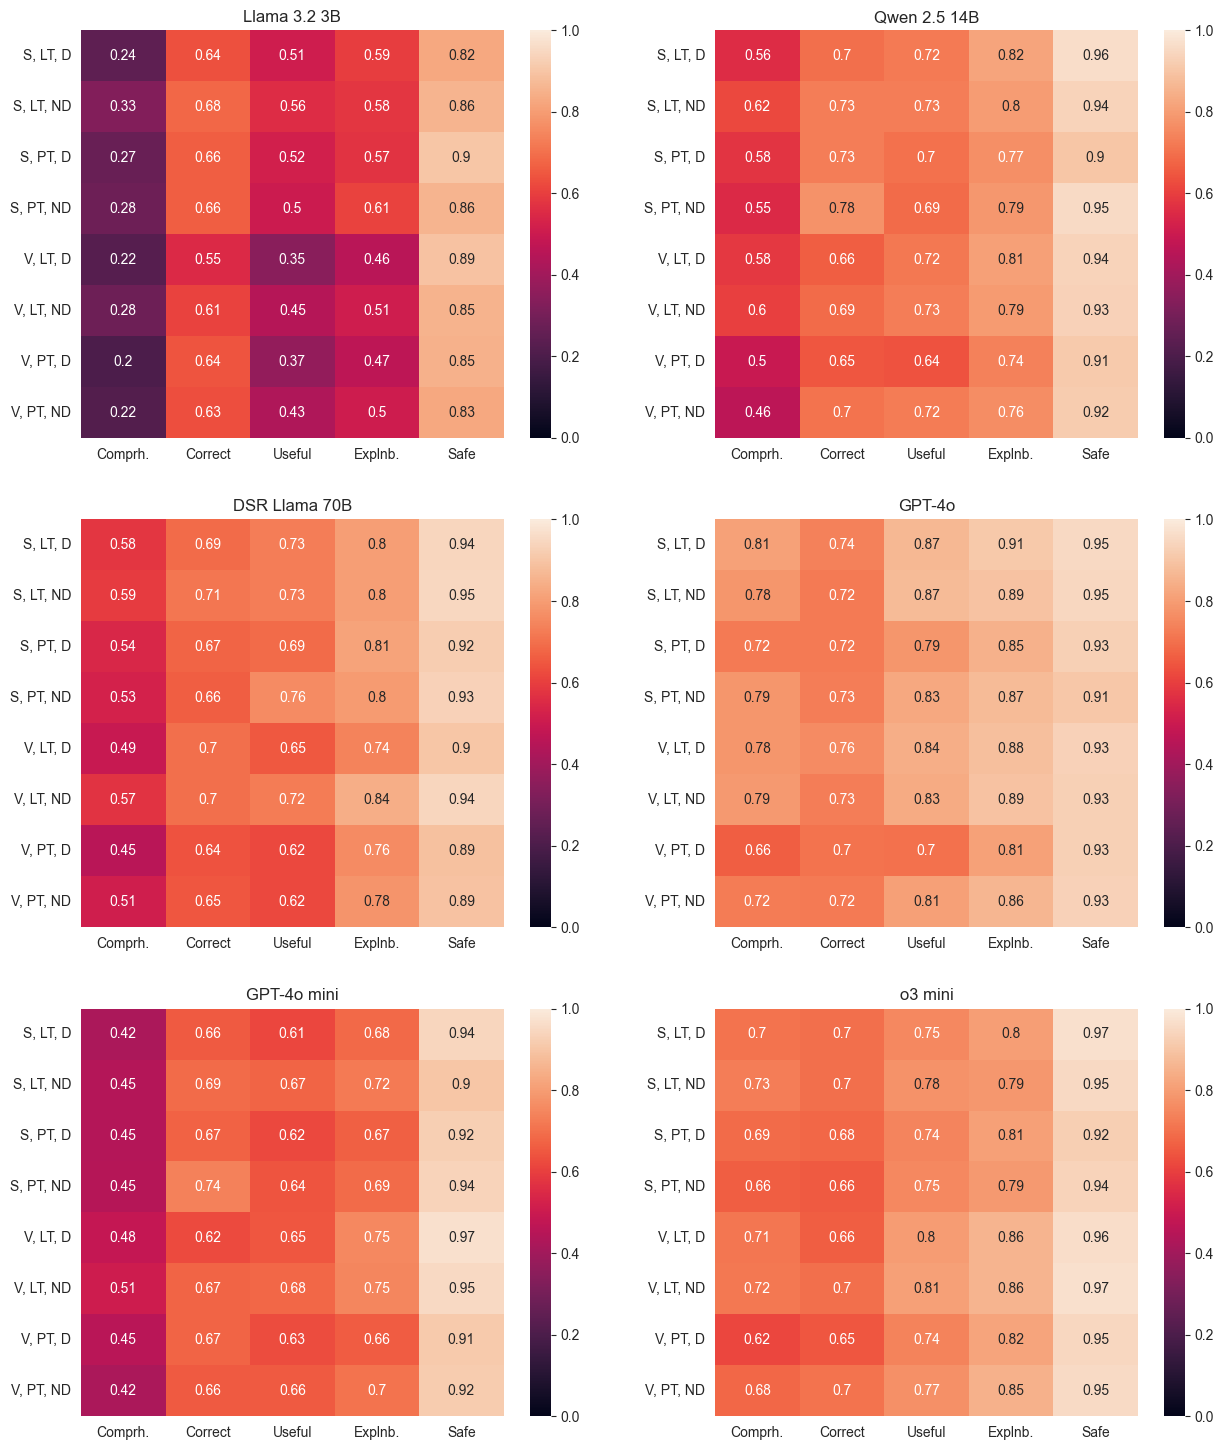

In [20]:
# df = pd.read_csv("/Users/u018480/Desktop/Projects/biochatter/benchmark/results/judge_responses.csv")

subtasks = {
    "exp_1": {
        "Short and List-Style": ["short", "list"],
        "Verbose and List-Style": ["verbose", "list"],
        "Short and Paragraph-Style": ["short", ":paragraph"],
        "Verbose and Paragraph-Style": ["verbose", ":paragraph"],
        "Short and No Distractor": ["short", "no_distractor"],
        "Verbose and No Distractor": ["verbose", "no_distractor"],
        "Short and Distractor": ["short", ":distractor"],
        "Verbose and Distractor": ["short", ":distractor"],
        "List-Style and No Distractor": ["list", "no_distractor"],
        "Paragraph-Style and No Distractor": [":paragraph", "no_distractor"],
        "List-Style and Distractor": ["list", ":distractor"],
        "Paragraph-Style and Distractor": [":paragraph", ":distractor"],
    },
    "exp_2": {
        "S, LT, ND": ["short", "list", "no_distractor"],
        "V, LT, ND": ["verbose", "list", "no_distractor"],
        "S, LT, D": ["short", "list", ":distractor"],
        "V, LT, D": ["verbose", "list", ":distractor"],
        "S, PT, ND": ["short", ":paragraph", "no_distractor"],
        "V, PT, ND": ["verbose", ":paragraph", "no_distractor"],
        "S, PT, D": ["short", ":paragraph", ":distractor"],
        "V, PT, D": ["verbose", ":paragraph", ":distractor"],
    }
}

metrics = [
    "correctness",
    "comprehensiveness",
    "usefulness",
    "interpretability_explainability",
    "toxicity",
]

test_subtype = "rag"

for key in list(subtasks.keys()):
    extension_combination_df = []
    helper_frames = []
    for metric in metrics:
        for subtask_name, subtask_pair in subtasks[key].items():
            if len(subtask_pair) == 2:
                filtered_frame = score_helper(df = df[(df["metric"] == metric) & 
                                    (df["subtask"].str.contains(subtask_pair[0])) & 
                                    (df["subtask"].str.contains(subtask_pair[1])) & 
                                    (df["subtask"].str.startswith(test_subtype))])[2]
            else:
                filtered_frame = score_helper(df = df[(df["metric"] == metric) & 
                                    (df["subtask"].str.contains(subtask_pair[0])) & 
                                    (df["subtask"].str.contains(subtask_pair[1])) &
                                    (df["subtask"].str.contains(subtask_pair[2])) & 
                                    (df["subtask"].str.startswith(test_subtype))])[2]
            filtered_frame["subtask"] = subtask_name
            filtered_frame["metric"] = metric
            helper_frames.append(filtered_frame)
    extension_combination_df = pd.concat(helper_frames, ignore_index = True)
    extension_combination_df = map_columns(df = extension_combination_df, metric_mapping = metric_mapping, model_mapping = model_mapping)

    extension_combination_df.loc[extension_combination_df["metric"] == "Consideration of Toxicity", "score"] = 1 - extension_combination_df["score"]

    custom_metric_order = ["Comprehensiveness", "Correctness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"]
    custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "GPT-4o mini", "o3 mini"]
    extension_combination_df["metric"] = pd.Categorical(extension_combination_df["metric"], categories = custom_metric_order, ordered = True)
    extension_combination_df["evaluated_model"] = pd.Categorical(extension_combination_df["evaluated_model"], categories = custom_model_order, ordered = True)
    extension_combination_df = extension_combination_df.sort_values(["evaluated_model"]).reset_index(drop = True)

fig, axes = plt.subplots(3, 2, figsize=(15, 18))

for i, model in enumerate(extension_combination_df["evaluated_model"].unique()):
    helper_df = extension_combination_df[extension_combination_df["evaluated_model"] == model]
    pivot_df = helper_df.pivot(index = "subtask", columns = "metric", values = "score")

    sns.heatmap(pivot_df, annot = True, ax = axes.flat[i], vmin = 0.0, vmax = 1.0)
    axes.flat[i].set_title(model)
    axes.flat[i].set_xticklabels(["Comprh.", "Correct", "Useful", "Explnb.", "Safe"], rotation = 0)
    axes.flat[i].set_xlabel("")
    axes.flat[i].set_ylabel("")
# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/supplementary_figure_k4.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

## Supplementary Appendix L
#### Supplementary Figures L1 + L2, Supplementary Tables L1 + L2

In [21]:
def create_age_frame(dfs, age_groups, metrics, task_type):
    age_group_df_std, age_group_df_val = [], []

    for df in dfs:
        age_frame_std, age_frame_val = [], []

        for age_group, metric in [(a, m) for a in age_groups for m in metrics]:
            df_helper = df[(df["metric"] == metric) &
                           (df["age"] == age_group) &
                           (df["subtask"].str.startswith(task_type))]
            
            _std, _val = score_helper(df_helper)[2:4]

            _std["metric"], _std["age_group"] = metric, age_group
            _val["metric"], _val["age_group"] = metric, age_group

            age_frame_std.append(_std)
            age_frame_val.append(_val)

        age_group_df_std.append(pd.concat(age_frame_std))
        age_group_df_val.append(pd.concat(age_frame_val))
    return (age_group_df_std, age_group_df_val)

dfs = create_frames(df = df)
age_dfs_std, age_dfs_val = create_age_frame(
    dfs = dfs,
    metrics = [
        "correctness",
        "comprehensiveness",
        "usefulness",
        "interpretability_explainability",
        "toxicity",
    ],
    age_groups = [
        "young",
        "mid-aged/pregeriatric",
        "geriatric",
    ],
    task_type = "rag",
)

Bar 1: Height = 0.1585, Std = 0.0017
Bar 2: Height = 0.6730, Std = 0.0057
Bar 3: Height = 0.4449, Std = 0.0048
Bar 4: Height = 0.5437, Std = 0.0058
Bar 5: Height = 0.9386, Std = 0.0023
Bar 6: Height = 0.3094, Std = 0.0015
Bar 7: Height = 0.5750, Std = 0.0040
Bar 8: Height = 0.4790, Std = 0.0022
Bar 9: Height = 0.5339, Std = 0.0044
Bar 10: Height = 0.8438, Std = 0.0086
Bar 11: Height = 0.3518, Std = 0.0009
Bar 12: Height = 0.6317, Std = 0.0033
Bar 13: Height = 0.4670, Std = 0.0023
Bar 14: Height = 0.5268, Std = 0.0015
Bar 15: Height = 0.7455, Std = 0.0031
Bar 1: Height = 0.5060, Std = 0.0000
Bar 2: Height = 0.7136, Std = 0.0023
Bar 3: Height = 0.7372, Std = 0.0043
Bar 4: Height = 0.8267, Std = 0.0022
Bar 5: Height = 0.9659, Std = 0.0028
Bar 6: Height = 0.4982, Std = 0.0000
Bar 7: Height = 0.5429, Std = 0.0033
Bar 8: Height = 0.5848, Std = 0.0031
Bar 9: Height = 0.6638, Std = 0.0022
Bar 10: Height = 0.9210, Std = 0.0034
Bar 11: Height = 0.6933, Std = 0.0000
Bar 12: Height = 0.8500, Std =

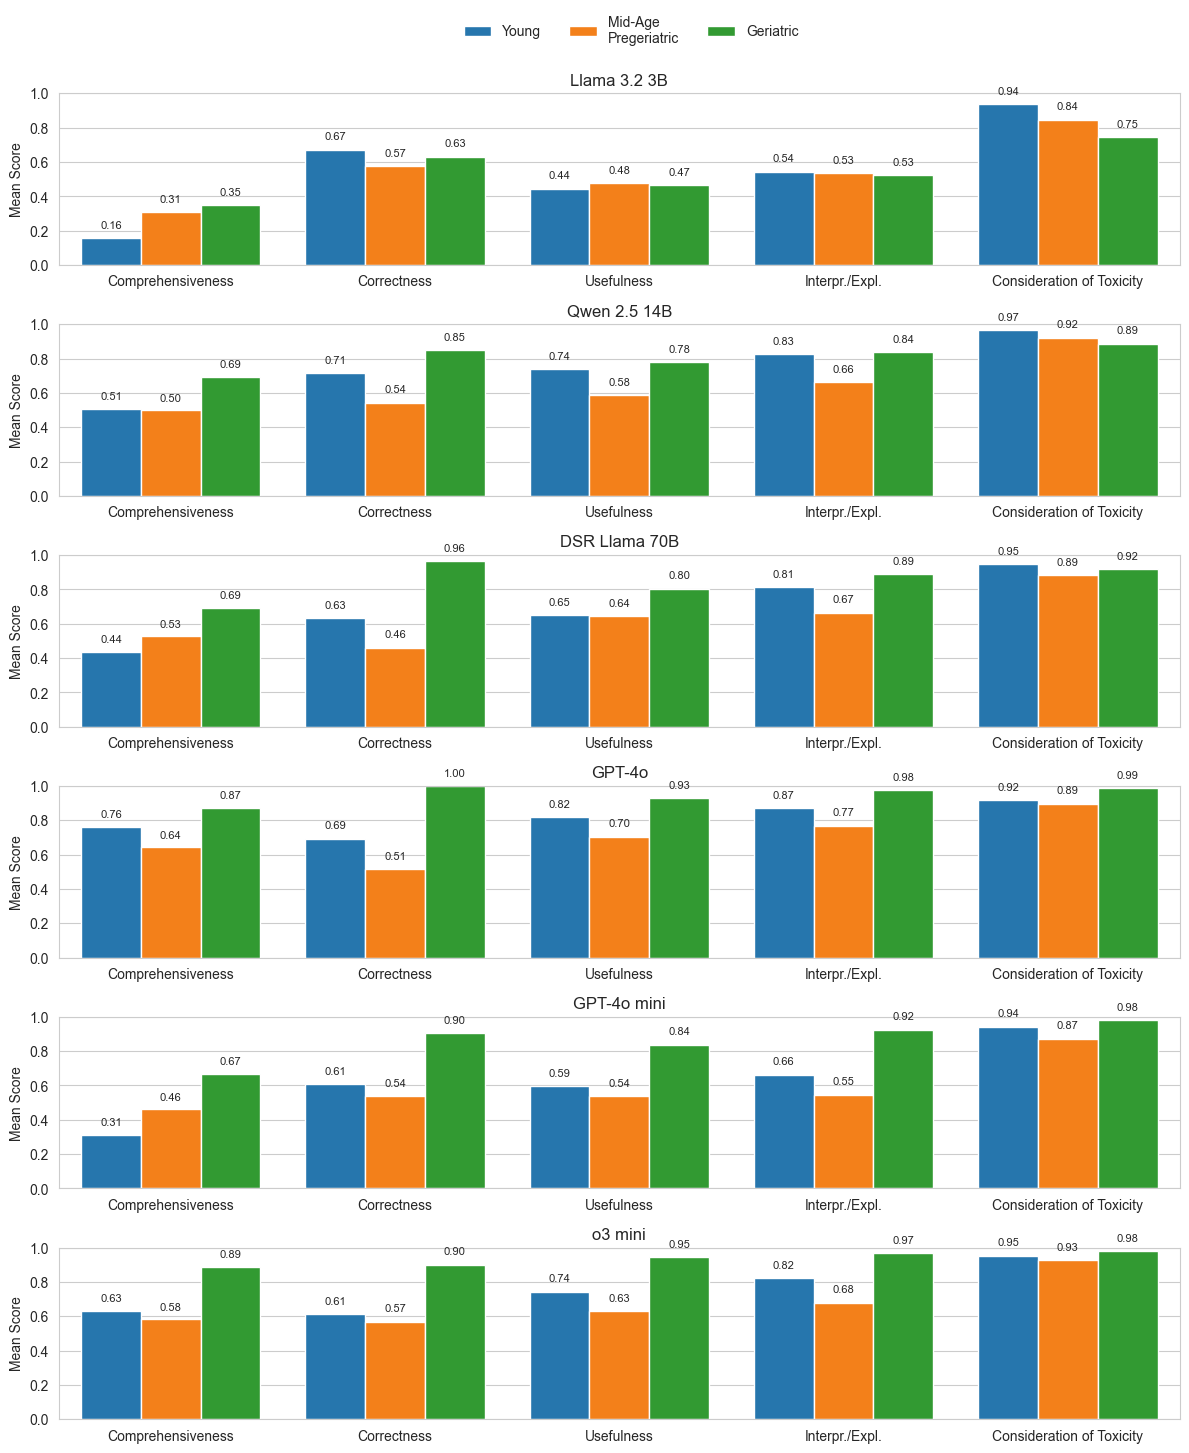

\begin{tabular}{llccccc}
\toprule
evaluated_model & age_group & Correctness & Comprehensiveness & Usefulness & Interpr./Expl. & Consideration of Toxicity \\
\midrule
\multirow{3}{*}{Llama 3.2 3B} & Young & 0.67 & 0.16 & 0.44 & 0.54 & 0.94 \\
 & Mid-Age
Pregeriatric & 0.57 & 0.31 & 0.48 & 0.53 & 0.84 \\
 & Geriatric & 0.63 & 0.35 & 0.47 & 0.53 & 0.75 \\
\multirow{3}{*}{Qwen 2.5 14B} & Young & 0.71 & 0.51 & 0.74 & 0.83 & 0.97 \\
 & Mid-Age
Pregeriatric & 0.54 & 0.50 & 0.58 & 0.66 & 0.92 \\
 & Geriatric & 0.85 & 0.69 & 0.78 & 0.84 & 0.89 \\
\multirow{3}{*}{DSR Llama 70B} & Young & 0.63 & 0.44 & 0.65 & 0.81 & 0.95 \\
 & Mid-Age
Pregeriatric & 0.46 & 0.53 & 0.64 & 0.67 & 0.89 \\
 & Geriatric & 0.96 & 0.69 & 0.80 & 0.89 & 0.92 \\
\multirow{3}{*}{GPT-4o} & Young & 0.69 & 0.76 & 0.82 & 0.87 & 0.92 \\
 & Mid-Age
Pregeriatric & 0.51 & 0.64 & 0.70 & 0.77 & 0.89 \\
 & Geriatric & 1.00 & 0.87 & 0.93 & 0.98 & 0.99 \\
\multirow{3}{*}{GPT-4o mini} & Young & 0.61 & 0.31 & 0.59 & 0.66 & 0.94 \\
 & Mid-A

/var/folders/g2/71rvhczs5jz338chhbpn8yh1w8w73f/T/ipykernel_3208/1742110717.py:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  latex_df['evaluated_model'] = latex_df.groupby('evaluated_model')['evaluated_model'].transform(


In [22]:
sns.set_style(style = "whitegrid")

# plt.figure(figsize = (8, 5))
fig, axes = plt.subplots(6, 1, figsize = (12, 14))

x = pd.concat(age_dfs_std, ignore_index = True)
custom_order = [
    "llama-3.2-3b-instruct",
    "qwen2.5-14b-instruct",
    "deepseek-r1-distill-llama-70b",
    "gpt-4o-2024-11-20",
    "gpt-4o-mini-2024-07-18",
    "o3-mini",
]
custom_metric_order = ["comprehensiveness", "correctness", "usefulness", "interpretability_explainability", "toxicity"]
x["evaluated_model"] = pd.Categorical(x["evaluated_model"], categories = custom_order, ordered = True)
x["metric"] = pd.Categorical(x["metric"], categories = custom_metric_order, ordered = True)
df_list = [g for b, g in x.groupby(["evaluated_model"], observed = False)]

x = pd.concat(age_dfs_val, ignore_index = True)
x["evaluated_model"] = pd.Categorical(x["evaluated_model"], categories = custom_order, ordered = True)
x["metric"] = pd.Categorical(x["metric"], categories = custom_metric_order, ordered = True)
df_strip_list = [g for b, g in x.groupby(["evaluated_model"], observed = False)]

df_group = []
for ax, df_, df_strip in zip(axes, df_list, df_strip_list):
    df_ = map_columns(df = df_, metric_mapping = metric_mapping, age_mapping = age_mapping, model_mapping = model_mapping)
    df_strip = map_columns(df = df_strip, metric_mapping = metric_mapping, age_mapping = age_mapping, model_mapping = model_mapping)

    df_ = df_.reset_index(drop = True)
    df_.loc[df_["metric"] == "Consideration of Toxicity", "score"] = 1 - df_["score"]

    df_strip = df_strip.reset_index(drop = True)
    df_strip.loc[df_strip["metric"] == "Consideration of Toxicity", "score"] = 1 - df_strip["score"]

    df_group.append(df_)

    plot = sns.barplot(
        x = "metric", 
        y = "score", 
        hue = "age_group", 
        data = df_,
        errorbar = ("sd"),
        # palette = colours, 
        saturation = 0.9,
        ax = ax,
    )

    std_values = df_["score_achieved_std"].to_numpy()
    for i, patch in enumerate(plot.patches[:len(std_values)]):
        std = std_values[i]
        extra = 0
        height = patch.get_height()
        print(f"Bar {i + 1}: Height = {height:.4f}, Std = {std:.4f}")
        if patch.get_height() > 0:
            ax.annotate(format(patch.get_height(), ".2f"),
                        (patch.get_x() + patch.get_width() / 2, min(patch.get_height() + std, 100) + extra),
                        ha = "center",
                        va = "center",
                        xytext = (0, 9),
                        textcoords = "offset points",
                        fontsize = 8) 
    ax.set_ylim(0, 1)
    ax.set_ylabel("Mean Score")
    ax.set_xlabel("")
    ax.legend().set_visible(False)
    ax.set_title(list(df_["evaluated_model"])[0])

handles, labels = plot.get_legend_handles_labels()
fig.legend(
    handles = handles[:len(df_["age_group"].unique())],
    labels = labels[:len(df_["age_group"].unique())],
    bbox_to_anchor=(0.53, 1.02),
    loc="center",
    ncols=3,
    frameon=False,
    borderaxespad=0.0,
)

plt.tight_layout()
# plt.savefig("/Users/u018480/Desktop/Projects/requirements_figures/supplementary_figure_l2.pdf", dpi = 300, bbox_inches = "tight")
plt.show()

latex_column_order = [
    "evaluated_model", "age_group", "Correctness",
    "Comprehensiveness", "Usefulness", "Interpr./Expl.", "Consideration of Toxicity"
]

latex_row_order = [
    "Young",
    "Mid-Age\nPregeriatric",
    "Geriatric"
]

latex_df = pd.concat(df_group).set_index(["evaluated_model", "age_group", "metric"])[["score"]].unstack()["score"].reset_index()

latex_df["age_group"] = pd.Categorical(latex_df["age_group"], categories = latex_row_order, ordered = True)
latex_df = latex_df.sort_values(["evaluated_model", "age_group"])

latex_df['evaluated_model'] = latex_df.groupby('evaluated_model')['evaluated_model'].transform(
    lambda x: [f'\\multirow{{{len(x)}}}{{*}}{{{x.iloc[0]}}}'] + [''] * (len(x) - 1)
)

latex_df = latex_df[latex_column_order]

latex_df = latex_df.to_latex(
    index = False,
    escape = False,
    column_format = "llccccc",
    float_format = "%.2f"
)

print(latex_df)

#### Supplementary Tables L3 + L4

In [23]:
df_pathologies = df[df["subtask"].str.startswith("rag")].copy()

models = [pretty_model for model, pretty_model in model_mapping.items()]

pathology_mapping = {
    "longevity:multimorbid_man": "Osteoporosis/\nSarcopenia",
    "longevity:underlying_condition_epicatechin": "Hypothyroidism",
    "longevity:underlying_condition_CR:": "Cushing Syndrome",
    "longevity:underlying_condition_CR_exercise": "Hypothyroidism",
    "longevity:hiit_rehab": "Coronary\nArtery Disease",
    "longevity:hiit_low_EF": "Coronary\nArtery Disease",
    "longevity:underlying_condition_regain_energy": "PCOS",
    "longevity:underlying_condition_CR_glucose:": "Acromegaly\n(GH excess)",
    "longevity:low_protein_diet": "Osteoporosis/\nSarcopenia",
}

dfs_pathologies = []
for task, pathology in pathology_mapping.items():
    for prompt, pretty_prompt in prompt_mapping.items():
        df_pathologies["subtask"] = df_pathologies["subtask"].apply(lambda x: pathology if task in x else x)
        dfs_pathologies.append(df_pathologies[
            (df_pathologies["subtask"] == pathology) &
            (df_pathologies["system_prompt"] == prompt)
        ])

df_all_pathologies = pd.concat(dfs_pathologies, ignore_index = True)
df_all_pathologies = map_columns(df_all_pathologies, metric_mapping = metric_mapping, model_mapping = model_mapping)

pathologies = df_all_pathologies["subtask"].unique()

helper_df = []
dfs_strip = []
for model in models:
    for pathology in pathologies:
        for prompt, pretty_prompt in prompt_mapping.items():
            frame = score_helper(df_all_pathologies[
                (df_all_pathologies["evaluated_model"] == model) &
                (df_all_pathologies["subtask"] == pathology) &
                (df_all_pathologies["system_prompt"] == prompt)
            ])[3]
            df_strip_helper = score_helper(df_all_pathologies[
                (df_all_pathologies["evaluated_model"] == model) &
                (df_all_pathologies["subtask"] == pathology) &
                (df_all_pathologies["system_prompt"] == prompt)
            ])[3]
            df_strip_helper["pathology"] = pathology
            df_strip_helper["system_prompt"] = prompt
            dfs_strip.append(df_strip_helper)

            frame["pathology"] = pathology
            frame["system_prompt"] = prompt
            helper_df.append(frame)
df_pathologies = pd.concat(helper_df, ignore_index = True)
df_strip = pd.concat(dfs_strip, ignore_index = True)

custom_model_order = ["Llama 3.2 3B", "Qwen 2.5 14B", "DSR Llama 70B", "GPT-4o", "GPT-4o mini", "o3 mini"]
df_strip["evaluated_model"] = pd.Categorical(df_strip["evaluated_model"], categories = custom_model_order, ordered = True)
df_pathologies["evaluated_model"] = pd.Categorical(df_pathologies["evaluated_model"], categories = custom_model_order, ordered = True)

latex_column_order = [
    "evaluated_model",
    "Osteoporosis/\nSarcopenia",
    "Hypothyroidism",
    "Cushing Syndrome",
    "Coronary\nArtery Disease",
    "PCOS",
    "Acromegaly\n(GH excess)",
]

latex_df = (
    df_strip.groupby(["evaluated_model", "pathology"], observed = False)["score"]
    .mean()
    .unstack("pathology")
    .reindex(columns=["Osteoporosis/\nSarcopenia",
                      "Hypothyroidism",
                      "Cushing Syndrome",
                      "Coronary\nArtery Disease",
                      "PCOS",
                      "Acromegaly\n(GH excess)",
    ])
    .reset_index()
)
latex_df = latex_df[latex_column_order]
latex_df = latex_df.to_latex(index = False, float_format = "%.2f")
print(latex_df)

\begin{tabular}{lrrrrrr}
\toprule
evaluated_model & Osteoporosis/
Sarcopenia & Hypothyroidism & Cushing Syndrome & Coronary
Artery Disease & PCOS & Acromegaly
(GH excess) \\
\midrule
Llama 3.2 3B & 0.38 & 0.18 & 0.34 & 0.41 & 0.35 & 0.20 \\
Qwen 2.5 14B & 0.43 & 0.14 & 0.30 & 0.56 & 0.18 & 0.23 \\
DSR Llama 70B & 0.67 & 0.08 & 0.18 & 0.45 & 0.30 & 0.21 \\
GPT-4o & 0.78 & 0.27 & 0.17 & 0.63 & 0.64 & 0.26 \\
GPT-4o mini & 0.57 & 0.07 & 0.04 & 0.57 & 0.19 & 0.18 \\
o3 mini & 0.75 & 0.10 & 0.09 & 0.62 & 0.45 & 0.13 \\
\bottomrule
\end{tabular}

